# Data Science Challenge

## Guidelines
Please complete the assignment inside this notebook (unless otherwise mentioned in the task). Make sure that the code can be understood and executed easily and results could be reproduced.

- Write production-ready code using OOP when relevant.
- For question 1,2 provide visualisations, when relevant.
- For question 2, prepare the slide deck to organise your report and attach it to your submission.
- Try to stick to the most popular scientific Python libraries.

## Input data for task 1
You should have received 2 csv files. 

* File *historian_extract.csv* contains the data from the set of sensors installed across the different lines of a plant, each one of them is counting number of specific events occured on the line.
    * The csv file contains the following fields:
        - **timestamp**
        - **tag**: name of the sensor (in format LXX_event_type1_counter, where LXX corresponds to the name of the line)
        - **value**: value of the counter
* File *mes_extract.csv* contains the information on the line state at any given moment in time, including process order, which is being processed on the line;
    * The csv file contains the following fields:
        - **line_state_id**: unique identifier of the line state
        - **line**: line name
        - **start_time**: start of the time-interval for the corresponding line state
        - **end_time**: end of the time-interval for the corresponding line state
        - **process_order**: process order code
    
All questions in this task are related to this data.

## Task 1: Data Processing
Understand the data and prepare the pipeline to transform the data from the raw format to the processed form described below. Explain your decisions and support them with the analysis/plots.

Format of the output data:
* **line** - name of the line
* **datetime** - timestamp corresponding to the start of the 30-min interval (30-min time aggregation e.g. 10:00:00, 10:30:00 etc.)
* **process_order** - process order code
* **type1_events_qty** - number of type 1 events occured
* **type2_events_qty** - number of type 2 events occured
* ...
* **tagN_events_qty** - number of type N events occured



## Loading the .csv files

The first file, historian_extract.csv, is saved in a dataframe called `his_raw`, while the second file, mes_extract.csv, is saved in a dataframe called `mes_raw`.

To obtain the desired final dataframe, it is necessary to merge both dataframes. However, prior to doing so, several modifications must be made to each dataframe.

In [9]:
# put in your code in the cells below

In [1]:
# delete all the variables
%reset -f

import pandas as pd

# read historian_extract.csv
his_raw = pd.read_csv("data/historian_extract.csv", parse_dates=["timestamp"], index_col=False)

# remove the UTC time zone information
his_raw["timestamp"] = his_raw["timestamp"].dt.tz_convert(None)

display(his_raw.head())
display(his_raw.info())

# read mes_extract.csv
mes_raw = pd.read_csv("data/mes_extract.csv", parse_dates=["start_time","end_time"], index_col=False)

display(mes_raw.head())
display(mes_raw.info())

,tag,timestamp,value
0,L1A_event_type1_counter,2022-06-30 15:48:14.991,0
1,L1A_event_type1_counter,2022-06-30 15:45:00.545,0
2,L1A_event_type1_counter,2022-06-28 22:14:28.095,0
3,L1A_event_type1_counter,2022-06-28 21:00:54.708,14
4,L1A_event_type1_counter,2022-06-28 21:00:53.238,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109609 entries, 0 to 109608
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   tag        109609 non-null  object        
 1   timestamp  109609 non-null  datetime64[ns]
 2   value      109609 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.5+ MB


None

,line_state_id,line,start_time,end_time,process_order
0,70C56F5E-88C7-430B-8416-8C82B92F2D14/0,L1C,2022-06-19 00:03:03,2022-06-19 00:03:14,916939569
1,C6CA07B5-5E68-402B-8C31-E63D849FBEC0/0,L1B,2022-06-19 00:03:03,2022-06-19 00:03:14,916939569
2,F1A87A98-B99B-40A1-BAD9-65B2E92A851E/0,L1A,2022-06-19 00:03:03,2022-06-19 00:03:13,916939548
3,F1A87A98-B99B-40A1-BAD9-65B2E92A851E/1,L1A,2022-06-19 00:03:13,2022-06-19 00:03:14,916939548
4,05E79205-878F-4FA5-97C8-5CD083715E1D/0,L1A,2022-06-19 00:03:14,2022-06-19 00:05:23,916939548


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17847 entries, 0 to 17846
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   line_state_id  17847 non-null  object        
 1   line           17847 non-null  object        
 2   start_time     17847 non-null  datetime64[ns]
 3   end_time       17847 non-null  datetime64[ns]
 4   process_order  17847 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 697.3+ KB


None

## Exploratory Data Analysis

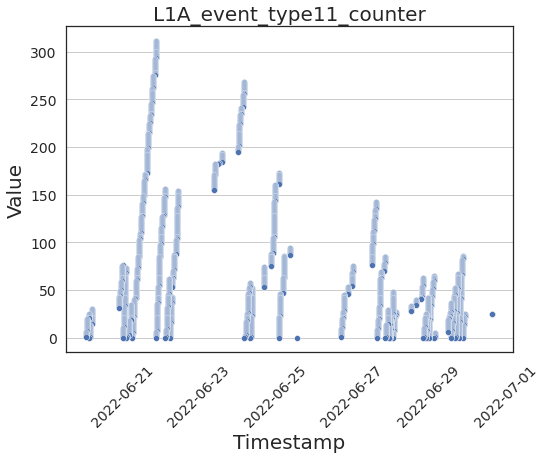

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import baby_potato as bp

# use str.contains() to filter the dataframe
df_eda = his_raw[his_raw['tag'].str.contains('L1A_event_type11_counter')]

x=df_eda['timestamp'] 
y=df_eda['value']
title='L1A_event_type11_counter'
xlabel='Timestamp'
ylabel='Value'

sns.set()
sns.set_theme(style='white')
fig = plt.subplots(figsize=(8, 6))
ax = sns.scatterplot(x=x, y=y)
plt.title(title, fontsize=20)
plt.xlabel(xlabel, fontsize=20)
plt.ylabel(ylabel, fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.grid(axis='y')
# plt.grid()
plt.show()


## Modifying and aggregating the historian_extract dataframe


In [3]:
# copy his_raw to avoid modify it
his = his_raw.copy()

# rename the column "old_column_name" to "new_column_name"
his = his.rename(columns={"timestamp": "datetime"})

# split the tag column in 4 additional columns
his[["line", "event", "type1", "counter"]] = his_raw["tag"].str.split("_", expand=True)

# drop some columns
his.drop(columns=["tag", "event", "counter"], inplace=True)

# set the timestamp column as the index
his.set_index("datetime", inplace=True)

# group the data by the type1 column
grouped = his.groupby(["line","type1"])

# resample the grouped data by 30-minute intervals and sum the value column
his_30m = grouped.resample('30T').agg({'value': 'sum'})

# reset the index to bring both the line and type1 columns back as columns
his_30m = his_30m.reset_index()
his = his.reset_index()

# rearrange the columns
his_30m = his_30m[["datetime", "line", "type1", "value"]]

# sort the columns by datetime
cols = ['datetime']
his_30m = his_30m.sort_values(by=cols)
his_30m = his_30m.reset_index(drop=True)

# Print the resulting dataframe
display(his.head())
display(his.info())

display(his_30m.head())
display(his_30m.info())


,datetime,value,line,type1
0,2022-06-30 15:48:14.991,0,L1A,type1
1,2022-06-30 15:45:00.545,0,L1A,type1
2,2022-06-28 22:14:28.095,0,L1A,type1
3,2022-06-28 21:00:54.708,14,L1A,type1
4,2022-06-28 21:00:53.238,13,L1A,type1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109609 entries, 0 to 109608
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  109609 non-null  datetime64[ns]
 1   value     109609 non-null  int64         
 2   line      109609 non-null  object        
 3   type1     109609 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.3+ MB


None

,datetime,line,type1,value
0,2022-06-20 01:00:00,L2B,type4,238
1,2022-06-20 01:00:00,L2B,type11,245
2,2022-06-20 01:00:00,L1B,type6,5
3,2022-06-20 01:00:00,L2A,type7,8
4,2022-06-20 01:00:00,L1B,type11,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27393 entries, 0 to 27392
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  27393 non-null  datetime64[ns]
 1   line      27393 non-null  object        
 2   type1     27393 non-null  object        
 3   value     27393 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 856.2+ KB


None

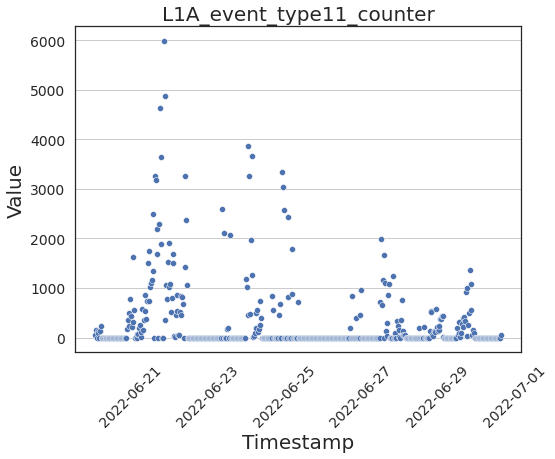

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import baby_potato as bp

# use str.contains() to filter the dataframe
# L1A_event_type11_counter
df_eda = his_30m[his_30m['line'].str.contains('L1A')]
df_eda = df_eda[df_eda['type1'].str.contains('type11')]

x=df_eda['datetime'] 
y=df_eda['value']
title='L1A_event_type11_counter'
xlabel='Timestamp'
ylabel='Value'

sns.set()
sns.set_theme(style='white')
fig = plt.subplots(figsize=(8, 6))
ax = sns.scatterplot(x=x, y=y)
plt.title(title, fontsize=20)
plt.xlabel(xlabel, fontsize=20)
plt.ylabel(ylabel, fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.grid(axis='y')
# plt.grid()
plt.show()


### Testing the historian_extract dataframe
The following section of code is to test if the previous data pipeline is working fine. Some value aggregation will be done by parts inside a for loop, and then compare it to the data pipeline values.

In [5]:
# choose a line
line = 'L2B'

# choose a type1
type1 = 'type5'

# set a to_datetime
start = pd.to_datetime("2022-06-20 01:00:00")

# number of 30-minutes intervals to test
INTERVALS = 500

TIMESPAN = pd.Timedelta(minutes=30)

# init
counter = 0

for i in range(INTERVALS) :

    # sweep datetime by 30-minutes intervals for a particular line and type1
    new_start = start + TIMESPAN * i
    new_end = new_start + TIMESPAN
    
    # filter the testing dataframe 
    his_test = his[(his['datetime'] >= new_start) & (his['datetime'] < new_end) & (his['line'] == line) & (his['type1'] == type1)] 
    
    # filter the pipeline dataframe 
    his_pipe = his_30m[(his_30m['datetime'] == new_start) & (his_30m['line'] == line) & (his_30m['type1'] == type1)]  

    if not his_test.empty :

        value_test = his_test['value'].sum()
        value_pipe = his_pipe['value'].tolist() # series to list
        counter = counter + 1 
        # print('test_result =', value_test)
        # print('dp_result =', value_pipe[0])

        if (value_test !=  value_pipe[0]) :
            print('Mismatch at test_result=', value_test, 'i=', i)

print('matches = ', counter)

matches =  49


### Pivoting the historian_extract dataframe

the output data should have the columns:

* **type1_events_qty** - number of type 1 events occured
* **type2_events_qty** - number of type 2 events occured
* ...
* **typeN_events_qty** - number of type N events occured

Since this information is in the `type1` column, the dataframe has to be pivoted from long to wide format. Missing values are filled with `NaN`.

In [6]:
import pandas as pd
import re

# pivot dataframe from long to wide
his_30m_pivot = his_30m.pivot(index=['datetime', 'line'], columns='type1', values='value')

# reset the MultiIndex
his_30m_pivot = his_30m_pivot.reset_index()

# find all column names that match the pattern "type\d+"
matching_cols = [col for col in his_30m_pivot.columns if re.match(r'type\d+', col)]

# replace the found column names with the requested names
for col in matching_cols:
    his_30m_pivot.rename(columns={col: col + "_events_qty"}, inplace=True)

# specify the columns to move to the end
cols = ['type10_events_qty', 'type11_events_qty']

# reorder the columns so that the columns specified in `cols` are located at the end
new_cols = [col for col in his_30m_pivot.columns if col not in cols] + cols
his_30m_pivot = his_30m_pivot[new_cols]

display(his_30m_pivot.head())
display(his_30m_pivot.info())


type1,datetime,line,type1_events_qty,type2_events_qty,type3_events_qty,type4_events_qty,type5_events_qty,type6_events_qty,type7_events_qty,type8_events_qty,type9_events_qty,type10_events_qty,type11_events_qty
0,2022-06-20 01:00:00,L1B,NaN,NaN,NaN,715.0,NaN,5.0,2.0,70.0,NaN,NaN,51.0
1,2022-06-20 01:00:00,L2A,70.0,217.0,NaN,726.0,NaN,NaN,8.0,2691.0,2709.0,NaN,350.0
2,2022-06-20 01:00:00,L2B,NaN,NaN,NaN,238.0,NaN,1.0,NaN,150.0,NaN,NaN,245.0
3,2022-06-20 01:30:00,L1A,NaN,NaN,NaN,378.0,NaN,1.0,NaN,780.0,150.0,NaN,45.0
4,2022-06-20 01:30:00,L1B,NaN,NaN,NaN,308.0,NaN,4.0,0.0,54.0,NaN,NaN,25.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           2548 non-null   datetime64[ns]
 1   line               2548 non-null   object        
 2   type1_events_qty   2295 non-null   float64       
 3   type2_events_qty   2496 non-null   float64       
 4   type3_events_qty   2445 non-null   float64       
 5   type4_events_qty   2548 non-null   float64       
 6   type5_events_qty   2488 non-null   float64       
 7   type6_events_qty   2532 non-null   float64       
 8   type7_events_qty   2543 non-null   float64       
 9   type8_events_qty   2548 non-null   float64       
 10  type9_events_qty   2528 non-null   float64       
 11  type10_events_qty  2422 non-null   float64       
 12  type11_events_qty  2548 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 258.

None

## Modifying the mes_extract dataframe


In [7]:
# copy mes_raw to avoid modify it
mes = mes_raw.copy()

# drop some columns
mes.drop(columns=["line_state_id"], inplace=True)

# calculate the time span
mes["time_span"] = mes["end_time"] - mes["start_time"]

# rearrange the columns
mes = mes[["start_time", "end_time", "time_span", "line", "process_order"]]

# sort the columns by start_time
cols = ['start_time']
mes = mes.sort_values(by=cols)

display(mes.head())
display(mes.info())

,start_time,end_time,time_span,line,process_order
0,2022-06-19 00:03:03,2022-06-19 00:03:14,0 days 00:00:11,L1C,916939569
1,2022-06-19 00:03:03,2022-06-19 00:03:14,0 days 00:00:11,L1B,916939569
2,2022-06-19 00:03:03,2022-06-19 00:03:13,0 days 00:00:10,L1A,916939548
3,2022-06-19 00:03:13,2022-06-19 00:03:14,0 days 00:00:01,L1A,916939548
4,2022-06-19 00:03:14,2022-06-19 00:05:23,0 days 00:02:09,L1A,916939548


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17847 entries, 0 to 17846
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   start_time     17847 non-null  datetime64[ns] 
 1   end_time       17847 non-null  datetime64[ns] 
 2   time_span      17847 non-null  timedelta64[ns]
 3   line           17847 non-null  object         
 4   process_order  17847 non-null  int64          
dtypes: datetime64[ns](2), int64(1), object(1), timedelta64[ns](1)
memory usage: 836.6+ KB


None

### Splitting rows with time_span greater than 30 minutes

To ensure that the final output data only includes intervals of 30 minutes, it is necessary to divide the larger intervals in the `mes` dataframe.

In [8]:
import pandas as pd

TIMESPAN = pd.Timedelta(minutes=30)

# filter rows with time_span larger than 30 minutes
mes_ts_long = mes[(mes['time_span'] > TIMESPAN) ]  

# filter rows with time_span shorter or equal to 30 minutes
mes_ts_short = mes[(mes['time_span'] <= TIMESPAN) ]  

# initialize empty list to store new rows
new_rows = []

# split rows with 'time_span' > TIMESPAN in 30-minutes interval(s) and a remaining interval
for i, row in mes_ts_long.iterrows():
    diff = row['end_time'] - row['start_time']
    n = int(diff.total_seconds() // (30 * 60))
    TIMESPAN = pd.Timedelta(minutes=30)
    for j in range(n):
        new_start = row['start_time'] + j * TIMESPAN
        new_end = new_start + TIMESPAN
        timespan = new_end - new_start
        new_row = pd.DataFrame({'start_time': [new_start], 'end_time': [new_end], 
                    'time_span': timespan, 'line': [row['line']], 'process_order': [row['process_order']] })
        new_rows.append(new_row)
    remain_time = row['end_time'] - new_end
    if remain_time > pd.Timedelta(minutes=0):
        new_start = new_end
        new_end = new_start + remain_time
        timespan = new_end - new_start
        new_row = pd.DataFrame({'start_time': [new_start], 'end_time': [new_end], 
                    'time_span': timespan, 'line': [row['line']], 'process_order': [row['process_order']] })
        new_rows.append(new_row)

# dataframe with new_rows
mes_30m = pd.concat(new_rows, axis=0, ignore_index=True)

# append rows with 'time_span' <= TIMESPAN 
mes_30m = mes_30m.append(mes_ts_short)

# sort rows by start_time
mes_30m = mes_30m.sort_values(by='start_time')

display(mes_30m.head())
display(mes_30m.info())


,start_time,end_time,time_span,line,process_order
0,2022-06-19 00:03:03,2022-06-19 00:03:14,0 days 00:00:11,L1C,916939569
1,2022-06-19 00:03:03,2022-06-19 00:03:14,0 days 00:00:11,L1B,916939569
2,2022-06-19 00:03:03,2022-06-19 00:03:13,0 days 00:00:10,L1A,916939548
3,2022-06-19 00:03:13,2022-06-19 00:03:14,0 days 00:00:01,L1A,916939548
4,2022-06-19 00:03:14,2022-06-19 00:05:23,0 days 00:02:09,L1A,916939548


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19004 entries, 0 to 17846
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   start_time     19004 non-null  datetime64[ns] 
 1   end_time       19004 non-null  datetime64[ns] 
 2   time_span      19004 non-null  timedelta64[ns]
 3   line           19004 non-null  object         
 4   process_order  19004 non-null  int64          
dtypes: datetime64[ns](2), int64(1), object(1), timedelta64[ns](1)
memory usage: 890.8+ KB


None

### Adjust `start_time` to 30-minute intervals in mes_extract

The `start_time` column is rounded to the nearest and earliest 30-minute interval, such as 10:00, 10:30, etc. For example, if start_time is equal to 10:29, it would be rounded to 10:00 (floor rounding).

In [9]:
# drop some columns
mes_30m_flr = mes_30m.drop(columns=["end_time", "time_span"])

# rename the column "old_column_name" to "new_column_name"
mes_30m_flr = mes_30m_flr.rename(columns={"start_time": "datetime"})

# round down a datetime object to the nearest 30 minute interval. 
mes_30m_flr['datetime'] = mes_30m_flr['datetime'].apply(lambda x: x.floor('30T'))

# keep only unique rows
mes_30m_flr.drop_duplicates(inplace=True)

# Print the resulting dataframe
display(mes_30m_flr.head())
display(mes_30m_flr.info())


,datetime,line,process_order
0,2022-06-19,L1C,916939569
1,2022-06-19,L1B,916939569
2,2022-06-19,L1A,916939548
11,2022-06-19,L2A,916939573
0,2022-06-19,L2B,916939573


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3131 entries, 0 to 17846
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       3131 non-null   datetime64[ns]
 1   line           3131 non-null   object        
 2   process_order  3131 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 97.8+ KB


None

## Final merging of dataframes

Finally, dataframes `mes_30m_flr` and `his_30m_pivot` are inner joint by both `datetime` and `line` columns.

Format of the output data:
* **line** - name of the line
* **datetime** - timestamp corresponding to the start of the 30-min interval (30-min time aggregation e.g. 10:00:00, 10:30:00 etc.)
* **process_order** - process order code
* **type1_events_qty** - number of type 1 events occured
* **type2_events_qty** - number of type 2 events occured
* ...
* **typeN_events_qty** - number of type N events occured

In [10]:
output_tmp = pd.merge(mes_30m_flr, his_30m_pivot, on=['datetime', 'line'], how='inner')

# specify the columns to rearrange
cols = ["line", "datetime", 'process_order']

# reorder the columns so that the columns specified in `cols` are at the beginning
new_cols = cols + [col for col in his_30m_pivot.columns if col not in cols] 
output_data = output_tmp[new_cols]

# Print the resulting dataframe
display(output_data.head())
display(output_data.info())

,line,datetime,process_order,type1_events_qty,type2_events_qty,type3_events_qty,type4_events_qty,type5_events_qty,type6_events_qty,type7_events_qty,type8_events_qty,type9_events_qty,type10_events_qty,type11_events_qty
0,L2A,2022-06-20 01:00:00,916939552,70.0,217.0,NaN,726.0,NaN,NaN,8.0,2691.0,2709.0,NaN,350.0
1,L1B,2022-06-20 01:00:00,916939561,NaN,NaN,NaN,715.0,NaN,5.0,2.0,70.0,NaN,NaN,51.0
2,L2B,2022-06-20 01:00:00,916939552,NaN,NaN,NaN,238.0,NaN,1.0,NaN,150.0,NaN,NaN,245.0
3,L2A,2022-06-20 01:30:00,916939552,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0
4,L2B,2022-06-20 01:30:00,916939552,NaN,NaN,NaN,0.0,NaN,0.0,16.0,105.0,NaN,NaN,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2722 entries, 0 to 2721
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   line               2722 non-null   object        
 1   datetime           2722 non-null   datetime64[ns]
 2   process_order      2722 non-null   int64         
 3   type1_events_qty   2442 non-null   float64       
 4   type2_events_qty   2664 non-null   float64       
 5   type3_events_qty   2608 non-null   float64       
 6   type4_events_qty   2722 non-null   float64       
 7   type5_events_qty   2661 non-null   float64       
 8   type6_events_qty   2706 non-null   float64       
 9   type7_events_qty   2717 non-null   float64       
 10  type8_events_qty   2722 non-null   float64       
 11  type9_events_qty   2702 non-null   float64       
 12  type10_events_qty  2582 non-null   float64       
 13  type11_events_qty  2722 non-null   float64       
dtypes: datet

None

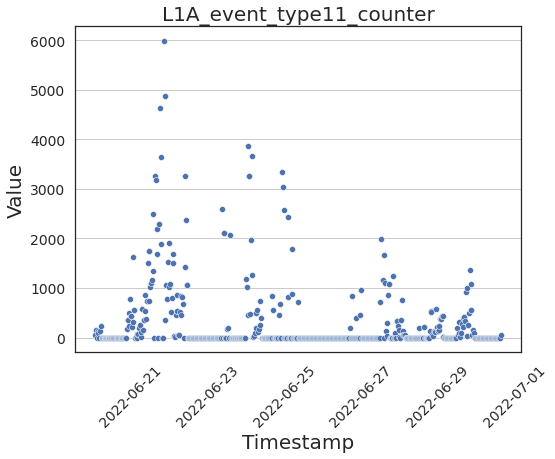

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import baby_potato as bp

# use str.contains() to filter the dataframe
# L1A_event_type11_counter
df_filtered = output_data[output_data['line'].str.contains('L1A')]

x=df_filtered['datetime'] 
y=df_filtered['type11_events_qty']
title='L1A_event_type11_counter'
xlabel='Timestamp'
ylabel='Value'

sns.set()
sns.set_theme(style='white')
fig = plt.subplots(figsize=(8, 6))
ax = sns.scatterplot(x=x, y=y)
plt.title(title, fontsize=20)
plt.xlabel(xlabel, fontsize=20)
plt.ylabel(ylabel, fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.grid(axis='y')
# plt.grid()
plt.show()


## Input data for task 2
You should have received 1 excel file. 

* File *baby_potato_manufacturing.xlsx* contains the data describing process parameters/conditions for the produced batches together with characteristics of the final product (see business case and process description below). 
    * The csv file contains the following fields:
        - **Start date**
        - **Variety Code**
        - **Origin**
        - **Discoloration fraction**
        - **Days since harvest**
        - **Sugar content**
        - **Tank temperature**
        - **Time in tank (seconds)**
        - **Percentage anti-foam in water**
        - **Time since last water change (minutes)**
        - **Fat temperature**
        - **Time in oven (seconds)**
        - **Polar fraction of fat**
        - **FFA in fat**
        - **Average temperature after oven**
        - **Scraper speed**
        - **Color after oven**
        - **Color after oven (numeric)**
        - **Waste after oven**
        - **Ambient Temperature**
        - **Humidity**

All questions in this task are related to this data.

## Task 2: Production Optimization
The goal of this task is to solve business case involving the development of the analytical model using the provided data.

**Business case:**
Company "Baby Potato" manufactures packaged baked potato and aims to produce the product with *optimal* color, while keeping the raw materials waste at *minimum*. See production diagram attached.
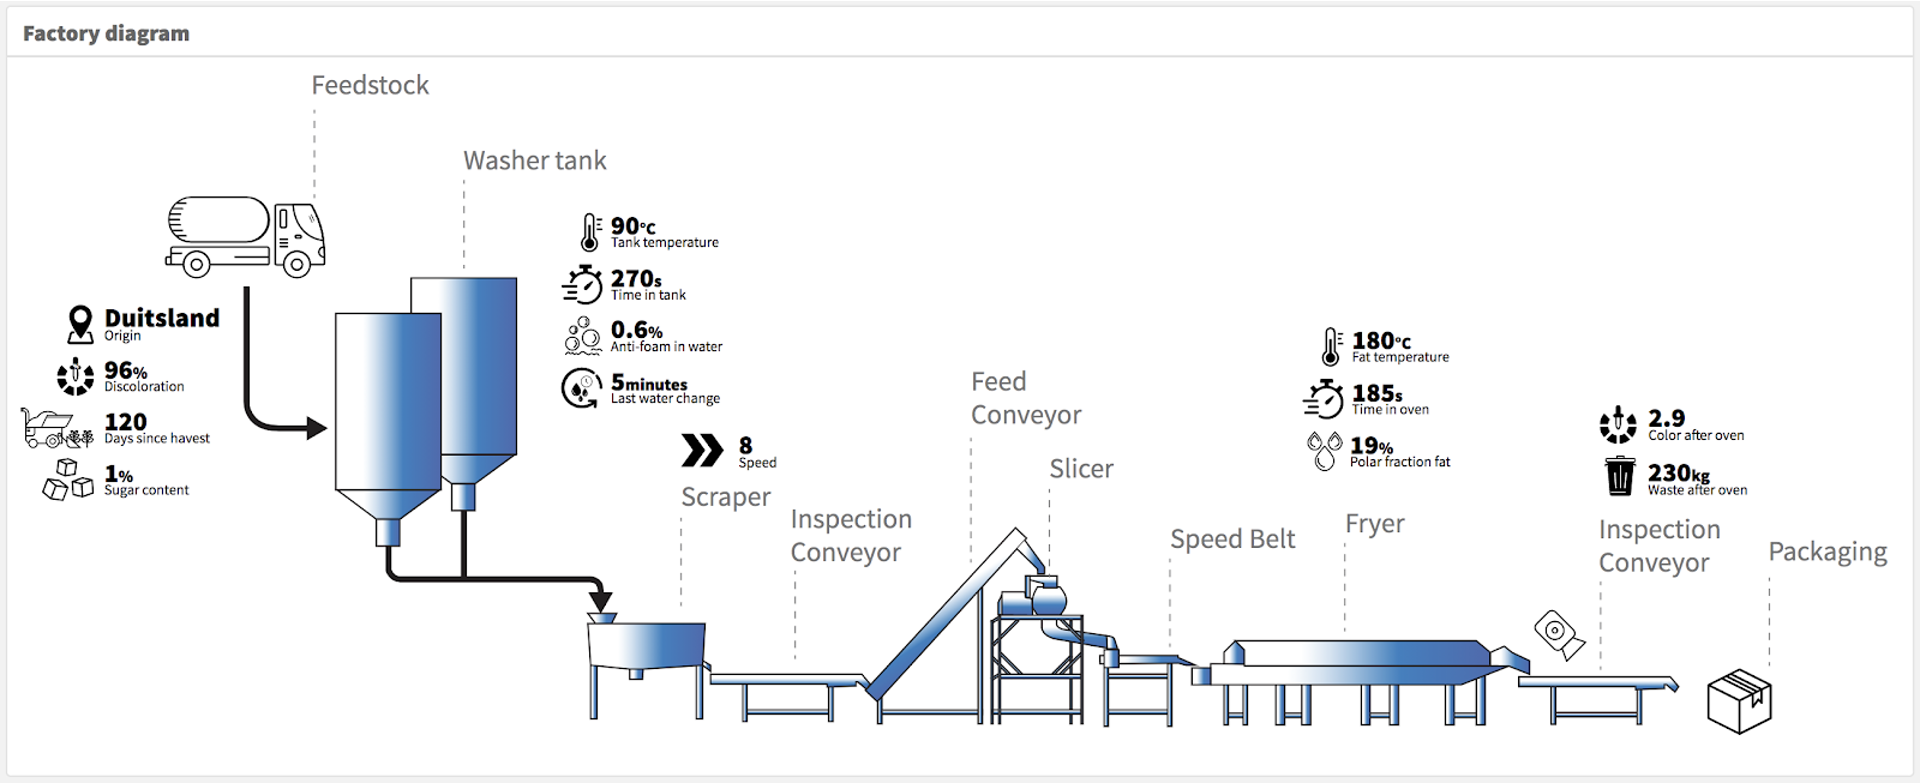




Your task as a data scientist, is to solve this problem using machine learning/modeling techniques and report your findings on how to improve the product color and reduce the waste to the *Head of production* of "Baby Potato".

Report your findings and code for the solution to us.


## Exploratory data analysis

### Loading the data

As usual, the first step is to load the data and do a preliminary exploratory data analysis. No null values are detected (NA, NaN) in the data.

In [12]:
# put in your code in the cells below

In [13]:
# delete all the variables
%reset -f

import pandas as pd
import baby_potato as bp

# Reading the excel file into a dataframe
dataraw = pd.read_excel("data/baby_potato_manufacturing.xlsx", parse_dates=["Start date"], index_col=False)

### Preprocessing the raw data

In [14]:

# Replace commas with dots in the dataframe
dataraw = dataraw.replace(',', '.', regex=True)

# Select the float columns and convert them to float64
dataraw = dataraw.astype({'Variety Code': 'float64', 
                          'Origin': 'string', 
                          'Discoloration fraction': 'float64', 
                          'Days since harvest': 'float64',
                          'Sugar content': 'float64',    
                          'Tank temperature': 'float64', 
                          'Time in tank (seconds)': 'float64',   
                          'Percentage anti-foam in water': 'float64', 
                          'Time since last water change (minutes)': 'float64',
                          'Fat temperature': 'float64',    
                          'Time in oven (seconds)': 'float64', 
                          'Polar fraction of fat': 'float64',    

                          'FFA in fat': 'float64', 
                          'Average temperature after oven': 'float64',   
                          'Scraper speed': 'float64', 
                          'Color after oven': 'string',
                          'Color after oven (numeric)': 'float64',    
                          'Waste after oven': 'float64', 
                          'Ambient Temperature': 'float64',        
                          'Humidity': 'float64',                                                                                                                    
                          })

display(dataraw.head())
display(dataraw.info())


,Start date,Variety Code,Origin,Discoloration fraction,Days since harvest,Sugar content,Tank temperature,Time in tank (seconds),Percentage anti-foam in water,Time since last water change (minutes),...,Time in oven (seconds),Polar fraction of fat,FFA in fat,Average temperature after oven,Scraper speed,Color after oven,Color after oven (numeric),Waste after oven,Ambient Temperature,Humidity
0,2020-10-06 09:38:43,1.0,Nederland,5.0,150.0,0.5,95.0,190.0,0.3,1000.0,...,200.0,18.0,1.0,72.0,8.0,3 - Goudbruin,3.0,160.0,26.0,60.0
1,2020-10-06 09:50:20,4.0,Nederland,5.0,152.0,0.7,97.0,190.0,0.3,100.0,...,205.0,17.0,0.9,75.0,9.0,4 - Bruin,4.0,290.0,28.0,59.0
2,2020-10-06 10:00:49,4.0,België,3.0,50.0,0.6,98.0,200.0,0.4,500.0,...,180.0,17.0,0.8,68.0,10.0,3 - Goudbruin,3.0,180.0,32.0,55.0
3,2020-10-06 10:04:43,4.0,Frankrijk,4.0,50.0,0.8,99.0,250.0,0.5,1500.0,...,180.0,20.0,1.0,68.0,10.0,4 - Bruin,4.0,320.0,32.0,55.0
4,2020-10-06 10:16:51,4.0,Frankrijk,4.0,55.0,0.9,98.0,230.0,0.4,600.0,...,182.0,19.0,1.0,67.0,10.0,3 - Goudbruin,3.0,250.0,28.0,60.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Start date                              50 non-null     datetime64[ns]
 1   Variety Code                            50 non-null     float64       
 2   Origin                                  50 non-null     string        
 3   Discoloration fraction                  50 non-null     float64       
 4   Days since harvest                      50 non-null     float64       
 5   Sugar content                           50 non-null     float64       
 6   Tank temperature                        50 non-null     float64       
 7   Time in tank (seconds)                  50 non-null     float64       
 8   Percentage anti-foam in water           50 non-null     float64       
 9   Time since last water change (minutes)  50 non-null     

None

In [15]:
# Rename the column "old_column_name" to "new_column_name"
data_tmp = dataraw.rename(columns={"Color after oven (numeric)": "Color"})
data_tmp = data_tmp.rename(columns={"Waste after oven": "Waste (kg)"})
data_tmp = data_tmp.rename(columns={"Sugar content": "Sugar content (%)"})
data_tmp = data_tmp.rename(columns={"Time in tank (seconds)": "Time in tank (s)"})
data_tmp = data_tmp.rename(columns={"Time in oven (seconds)": "Time in oven (s)"})
data_tmp = data_tmp.rename(columns={"Time since last water change (minutes)": "Time since last water change (m)"})
data_tmp = data_tmp.rename(columns={"Tank temperature": "Tank temperature (°C)"})
data_tmp = data_tmp.rename(columns={"Ambient Temperature": "Ambient temperature (°C)"})
data_tmp = data_tmp.rename(columns={"Fat temperature": "Fat temperature (°C)"})
data_tmp = data_tmp.rename(columns={"Percentage anti-foam in water": "Anti-foam in water (%)"})
data_tmp = data_tmp.rename(columns={"Average temperature after oven": "Avr temperature after oven (s)"})
data_tmp = data_tmp.rename(columns={"Discoloration fraction": "Discoloration fraction (%)"})
data_tmp = data_tmp.rename(columns={"Polar fraction of fat": "Polar fraction of fat (%)"})

# drop some variables
data = data_tmp.drop(columns=['Origin', 'Start date', 'Variety Code', 'Color after oven'])

# save the DataFrame to a pickle file
data.to_pickle('data_potato.pkl')

# Print the resulting dataframe
display(data.head())
display(data.info())
display(data.describe())


,Discoloration fraction (%),Days since harvest,Sugar content (%),Tank temperature (°C),Time in tank (s),Anti-foam in water (%),Time since last water change (m),Fat temperature (°C),Time in oven (s),Polar fraction of fat (%),FFA in fat,Avr temperature after oven (s),Scraper speed,Color,Waste (kg),Ambient temperature (°C),Humidity
0,5.0,150.0,0.5,95.0,190.0,0.3,1000.0,178.0,200.0,18.0,1.0,72.0,8.0,3.0,160.0,26.0,60.0
1,5.0,152.0,0.7,97.0,190.0,0.3,100.0,175.0,205.0,17.0,0.9,75.0,9.0,4.0,290.0,28.0,59.0
2,3.0,50.0,0.6,98.0,200.0,0.4,500.0,179.0,180.0,17.0,0.8,68.0,10.0,3.0,180.0,32.0,55.0
3,4.0,50.0,0.8,99.0,250.0,0.5,1500.0,178.0,180.0,20.0,1.0,68.0,10.0,4.0,320.0,32.0,55.0
4,4.0,55.0,0.9,98.0,230.0,0.4,600.0,179.0,182.0,19.0,1.0,67.0,10.0,3.0,250.0,28.0,60.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Discoloration fraction (%)        50 non-null     float64
 1   Days since harvest                50 non-null     float64
 2   Sugar content (%)                 50 non-null     float64
 3   Tank temperature (°C)             50 non-null     float64
 4   Time in tank (s)                  50 non-null     float64
 5   Anti-foam in water (%)            50 non-null     float64
 6   Time since last water change (m)  50 non-null     float64
 7   Fat temperature (°C)              50 non-null     float64
 8   Time in oven (s)                  50 non-null     float64
 9   Polar fraction of fat (%)         50 non-null     float64
 10  FFA in fat                        50 non-null     float64
 11  Avr temperature after oven (s)    50 non-null     float64
 12  Scraper sp

None

,Discoloration fraction (%),Days since harvest,Sugar content (%),Tank temperature (°C),Time in tank (s),Anti-foam in water (%),Time since last water change (m),Fat temperature (°C),Time in oven (s),Polar fraction of fat (%),FFA in fat,Avr temperature after oven (s),Scraper speed,Color,Waste (kg),Ambient temperature (°C),Humidity
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,9.570000,119.140000,1.516000,98.100000,215.000000,1.192000,433.540000,176.660000,193.620000,18.844000,0.942000,69.900000,9.480000,3.160000,241.180000,31.980000,62.200000
std,21.841734,105.886348,1.397134,12.370554,51.567273,0.637546,398.245397,7.924671,27.214109,2.985759,0.354038,3.157434,11.032864,1.149268,165.296479,3.814526,5.390846
min,1.000000,5.000000,0.200000,80.000000,150.000000,0.300000,5.000000,150.000000,160.000000,14.000000,0.300000,62.000000,2.000000,1.000000,50.000000,23.000000,52.000000
25%,3.000000,30.000000,0.600000,95.000000,190.000000,0.600000,76.250000,176.000000,180.000000,16.000000,0.725000,68.000000,8.000000,3.000000,165.000000,30.000000,59.000000
50%,4.000000,61.000000,0.950000,98.000000,200.000000,1.050000,375.000000,178.000000,187.500000,19.000000,1.000000,70.000000,8.000000,3.000000,210.000000,32.000000,62.000000
75%,5.000000,199.500000,2.000000,98.000000,225.000000,1.750000,600.000000,180.000000,200.000000,20.000000,1.100000,72.000000,8.000000,4.000000,253.750000,34.750000,65.000000
max,98.000000,350.000000,6.000000,180.000000,400.000000,3.000000,1800.000000,200.000000,300.000000,30.000000,2.300000,79.000000,85.000000,6.000000,1200.000000,43.000000,76.000000


### Correlation between all variables

Based on the correlation matrix, it appears that there is a significant correlation between the Color and Waste variables. Therefore, it may be beneficial to exclude one of these variables when attempting to model the other. This can help to avoid issues such as multicollinearity and overfitting, and create a more robust and reliable model.

Additionally, it is worth noting that these two variables exhibit a degree of correlation with the Sugar content variable. As a result, Sugar content is likely to be a significant feature that should be considered when developing a model. 

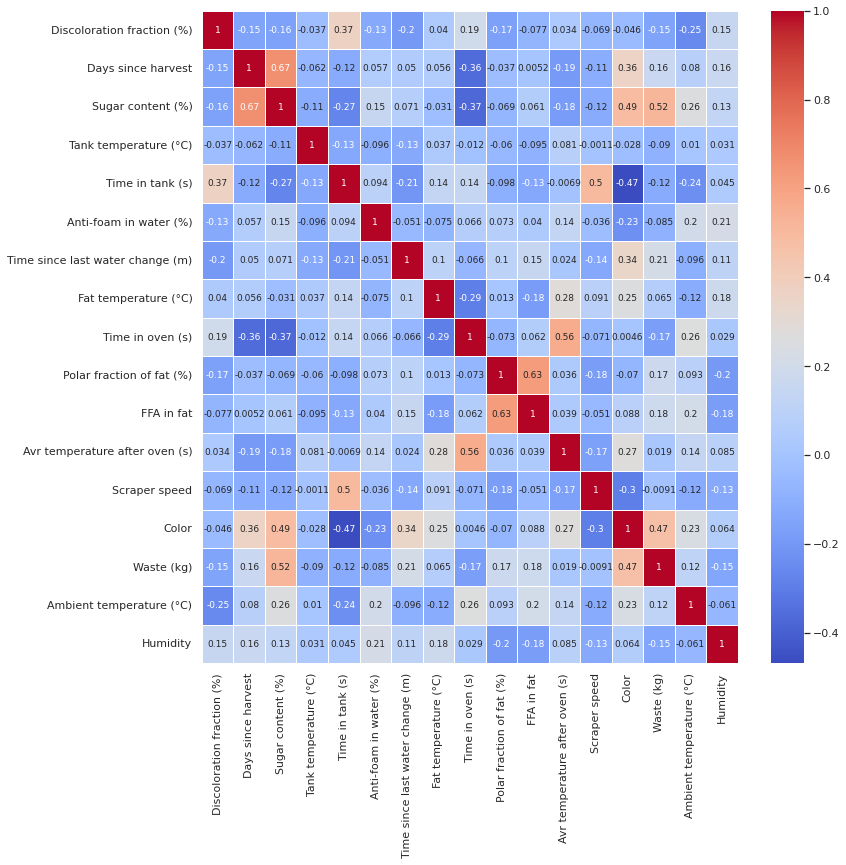

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')

corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 9}, cmap="coolwarm", linewidths=.5, ax=ax)
plt.show()

### Relationship between Color and Waste

As indicated by the correlation matrix, there is a positive correlation between the Color and Waste variables. This relationship is illustrated in the following figure, which demonstrates that as Color increases, so does Waste. Of particular interest is the observation that when Color equals 6, Waste is markedly high. This finding is consistent with the industrial process, as a Color value of 6 typically indicates that the potatoes have been overcooked, and the resulting production batch must be discarded.

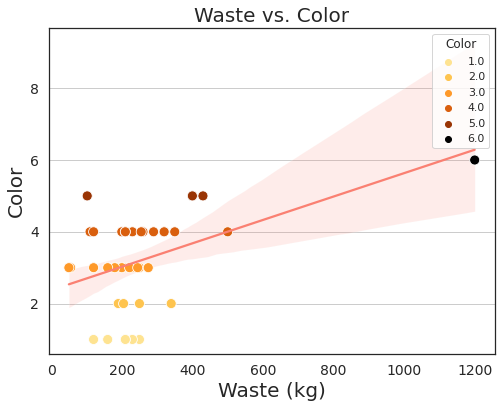

In [17]:
import pandas as pd
import baby_potato as bp

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')

x='Waste (kg)' 
y='Color' 
title='Waste vs. Color'
xlabel=x
ylabel=y

sns.set()
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x=x, y=y, data=data, scatter=False, color='salmon', ci=95)
sns.scatterplot(x=x, y=y, data=data, hue=y, s=100, 
                    palette=bp.color_palette() )
plt.title(title, fontsize=20)
plt.xlabel(xlabel, fontsize=20)
plt.ylabel(ylabel, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(axis='y')
# plt.grid()
plt.show()


## Pairplot

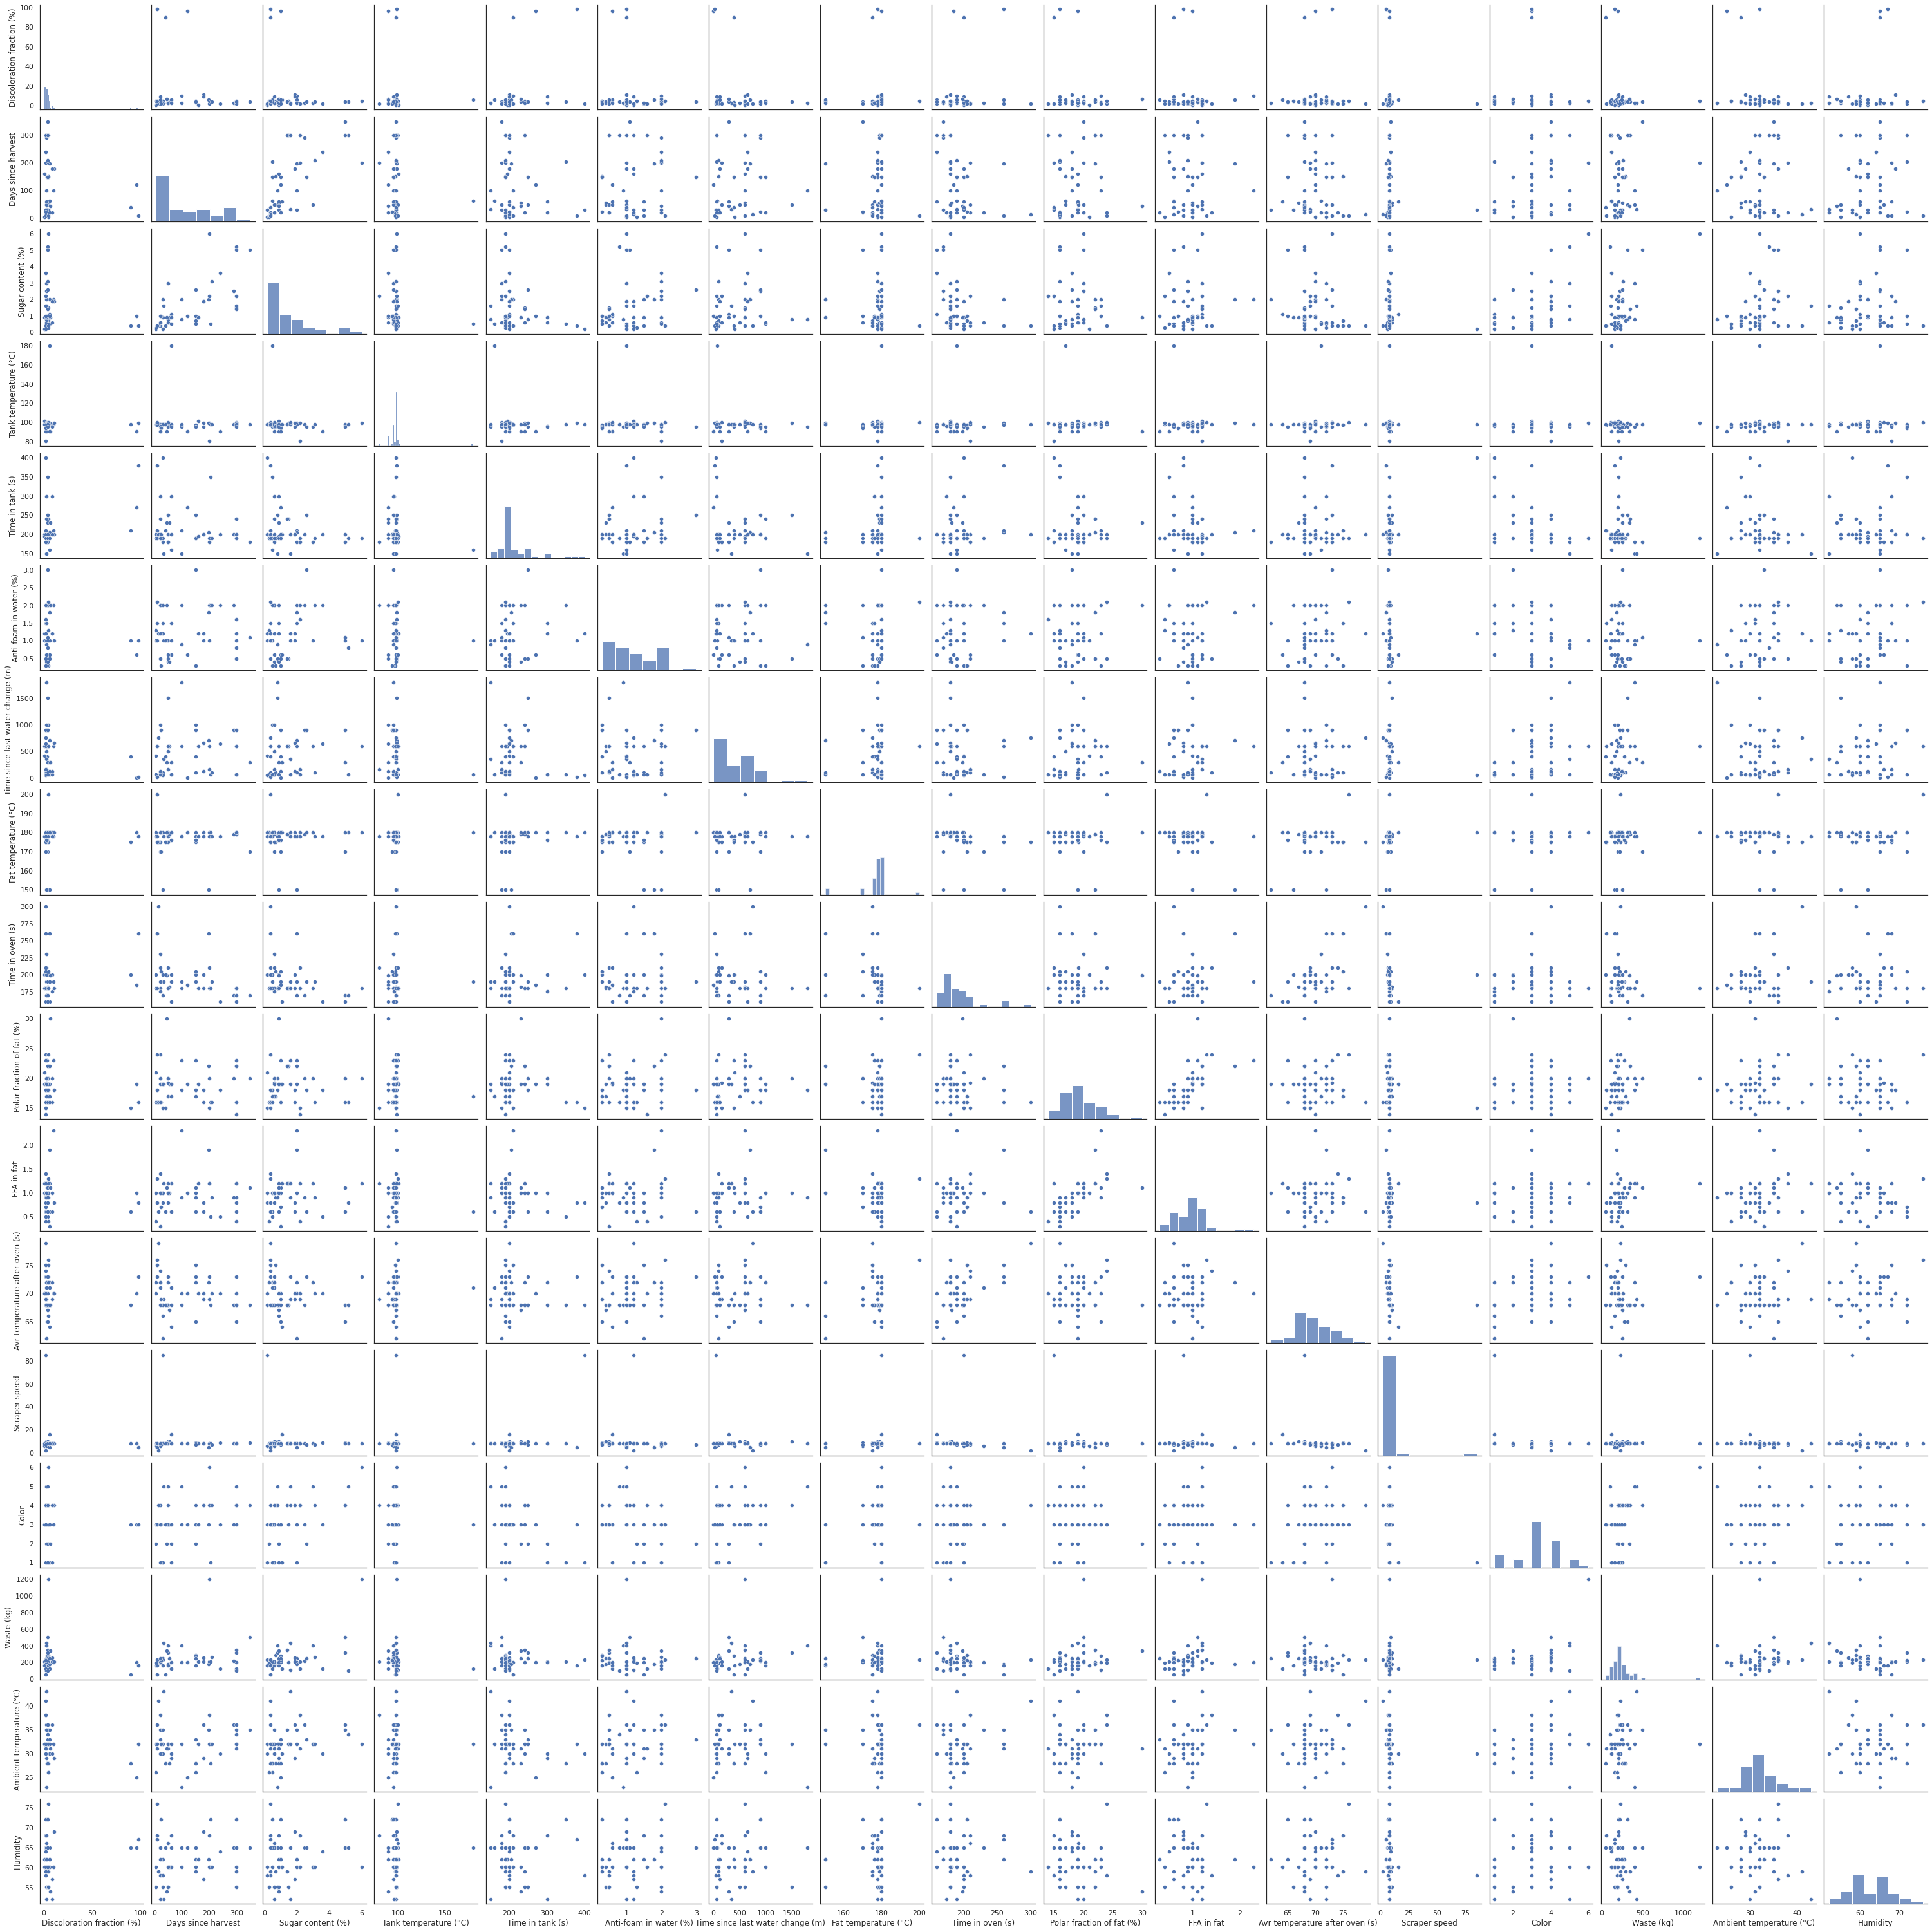

In [18]:
import pandas as pd
import baby_potato as bp

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')

sns.pairplot(data)

## Dropping variables

There are two pairs of very correlated parameters and one of them will be discarted, Sugar content and Days since harvest, and Polar fraction of fat and FFA in fat.


In [19]:
data = data.drop(columns=[ 'Days since harvest', 'Polar fraction of fat (%)', 'Scraper speed', 'Tank temperature (°C)'] )

# save the DataFrame to a pickle file
data.to_pickle('data_potato.pkl')

## Modeling Color as a classification problem

The primary objective of developing a model for the Color variable is to gain a better understanding of how the other variables contribute to the resulting color of the potatoes. Given that Color is an integer variable ranging from 1 to 6, predicting its value for future data points can be treated as a classification problem. To this end, a Gradient Boosting Classifier has been chosen as the appropriate classification method. This type of method provides valuable insights into the relative importance of the features used to build the model, which can be critical in identifying the key factors that drive the color of the potatoes. 

### Cross-validation Random Forest Classifier 

The process of generating Random Forest Classifier models involves using a cross-validation method to ensure robustness and accuracy. During each iteration, the data is randomly sampled, and new training and testing datasets are constructed. This helps to ensure that the resulting models are both reliable and effective in predicting the Color variable for new input variables values. 

Upon completing the training stage, it became evident that the accuracy of the model is relatively low, hovering around 0.3 out of a maximum score of 1. This indicates that the model can only predict the Color variable from the other features with an accuracy of approximately 30%. 

Notably, the classifier struggles more to accurately predict classes 2, 5, and 6, which are also underrepresented in the dataset. This suggests that the model may benefit from additional data points or features that can better capture the underlying patterns and trends in the data.

In [20]:
import numpy as np
import pandas as pd
import baby_potato as bp
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings('always') 

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')

# drop waste
data_color = data.drop(['Waste (kg)'] , axis=1)

# number of cross validations
CV = 20

# init variables to store models' parameters
y_pred_l = np.empty((0, ), dtype=float)
y_test_l = []
acc_l = []
features_color_l = []
estimators_l = []

for i in range(CV) :

    # split data randomly
    X_train, y_train, X_test, y_test = bp.data_splitting (data_color, target='Color')

    # Define the classifier
    classifier = RandomForestClassifier()

    # Train the classifier on the training set
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)

    # Best features from a particular model
    features_color_l.append(classifier.feature_importances_ )

    y_pred_l = np.concatenate((y_pred_l, y_pred)) 
    y_test_l = np.concatenate((y_test_l, y_test)) 
    
    acc_l.append(accuracy)
    estimators_l.append(('tree%d' % i, classifier))


In [21]:
np.set_printoptions(precision=3)

# Print the results 
print("Model Accuracy :", round (np.mean(acc_l) , 3))
print('Classification report:')
print(classification_report(y_test_l, y_pred_l, zero_division=1))


Model Accuracy : 0.385
Classification report:
              precision    recall  f1-score   support

         1.0       0.17      0.07      0.10        27
         2.0       0.00      0.00      0.00        17
         3.0       0.50      0.86      0.64        78
         4.0       0.22      0.13      0.17        60
         5.0       0.00      0.00      0.00        12
         6.0       1.00      0.00      0.00         6

    accuracy                           0.38       200
   macro avg       0.32      0.18      0.15       200
weighted avg       0.32      0.39      0.31       200



Precision is the number of true positives divided by the number of true positives plus the number of false positives. The ability of a classification model to identify only the positive predictions. _Out of everyone predicted to have the disease, how many of them actually have it?_

Recall is the number of true positives divided by the number of true positives plus the number of false negatives. The ability of a model to identifies true positives within a data set. _Out of all the patients who have the disease, how many were correctly identified?_

F1 score: a single metric that combines recall and precision using the harmonic mean

### Color levels distribution

The dataset's histogram indicates that colors 2, 5, and 6 are under-represented, as shown below.

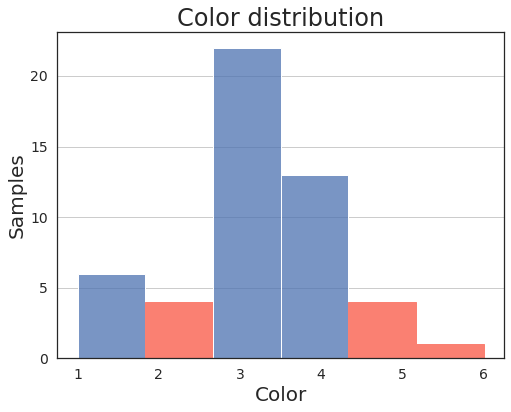

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.set()
sns.set_theme(style='white')
ax=sns.histplot(data['Color'], bins=6 )
# ax.axhline(y = 50/6,
#           color = "salmon", linestyle='--' , 
#           lw = 3, alpha=0.65)
# ax.annotate('Samples mean', xy=(5, 9), xytext=(5, 9))
ax.patches[1].set_color('salmon')
ax.patches[4].set_color('salmon')
ax.patches[5].set_color('salmon')
ax.grid(axis='y')
plt.title("Color distribution", fontsize=24)
plt.xlabel('Color', fontsize=20)
plt.ylabel('Samples', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Model accuracy distribution

The following histogram plot displays the distribution of the individual trained classification models, revealing that the majority of models have an average accuracy of approximately 0.3. 


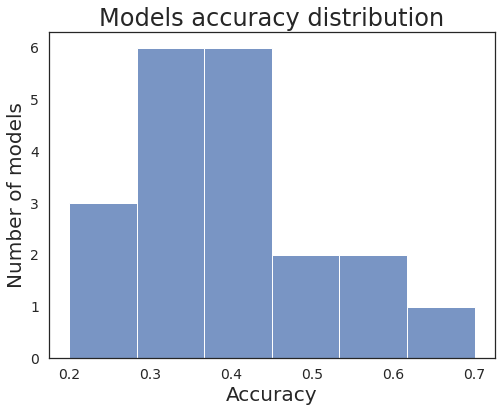

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(acc_l)
#Drawing a horizontal line at mean
plt.title("Models accuracy distribution", fontsize=24)
plt.xlabel('Accuracy', fontsize=20)
plt.ylabel('Number of models', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### Confusion matrix

A confusion matrix with a heatmap is a powerful tool to visually assess the performance of a classifier. Given the relatively low overall accuracy of the classifier, which hovers around 0.3, it is not surprising to find that the confusion matrix highlights some deficiencies in its performance. Specifically, we would expect the diagonal elements of the matrix to be close to 1, indicating accurate predictions. However, as revealed in the classification report, certain classes, such as 1, 3, and 4, show relatively good prediction performance. Nonetheless, other classes, such as 2, 5, and 6, present significant challenges for the model due to under representation. 

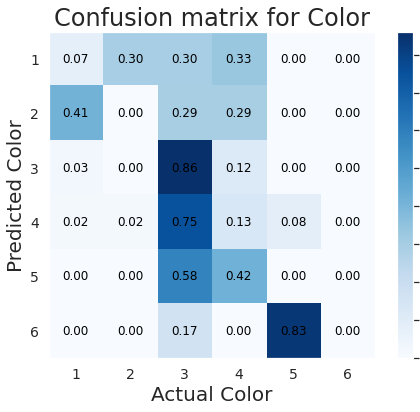

In [24]:
np.set_printoptions(precision=2)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_l,y_pred_l)

# Normalize the confusion matrix
normalized_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define the class names
class_names = ['1', '2', '3', '4', '5', '6']

# Plot the confusion matrix
sns.set()
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(normalized_matrix, cmap='Blues')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_ylabel('Predicted Color', fontsize=20)
ax.set_xlabel('Actual Color', fontsize=20)
ax.set_title('Confusion matrix for Color', fontsize=24)
plt.colorbar(im, format='')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Add text to each cell of the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, "{:.2f}".format(normalized_matrix[i, j]),
                       ha="center", va="center", color="black")

plt.show()


### Color key parameters 

While the model may not have performed optimally, it does provide valuable information about the features that have the greatest impact on predicting the Color variable. By identifying the key variables that influence the final color of the potatoes, it is possible to gain deeper insights into the factors that determine the success of the industrial process. Armed with this information, adjustments can be made to the production process with the goal of achieving the ideal color for the cooked potatoes. Though additional research and experimentation may be necessary to refine the model and improve its accuracy, the initial insights gained from the analysis can provide a solid foundation for future optimization efforts.

After cross-validation, the most important features are averaged and sorted in descending order. The ranking table below clearly indicates that the three most important variables in determining the Color of the potatoes are Time in tank, Days since harvest, and Sugar content. 

In [25]:
color_features = pd.DataFrame(data=np.mean(features_color_l, axis=0) ,
                             index=classifier.feature_names_in_ , 
                             columns=['weight'])

color_best_features = color_features.abs().sort_values(by='weight', ascending=False)

# save the DataFrame to a pickle file
color_features.to_pickle('color_features.pkl')
color_best_features.to_pickle('color_best_features.pkl')

display(color_best_features.head(10))

,weight
Sugar content (%),0.128832
Time in tank (s),0.122601
Time since last water change (m),0.116233
Humidity,0.100896
Avr temperature after oven (s),0.090091
Ambient temperature (°C),0.085092
Anti-foam in water (%),0.084206
Fat temperature (°C),0.074898
Time in oven (s),0.072073
FFA in fat,0.064522


### Color key parameters plots

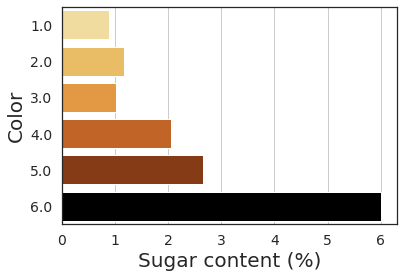

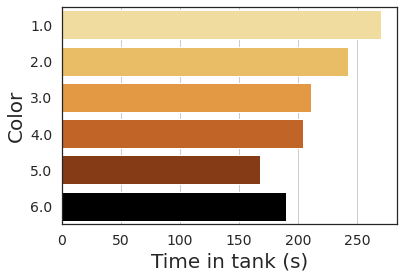

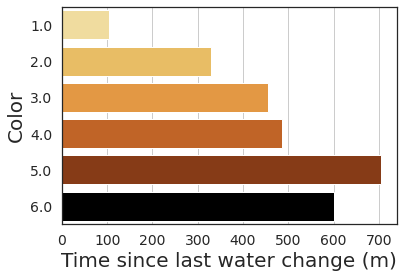

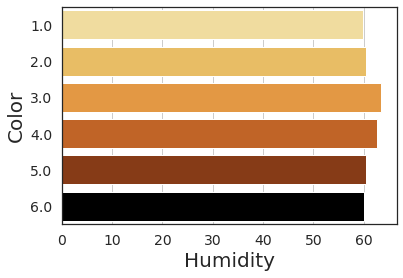

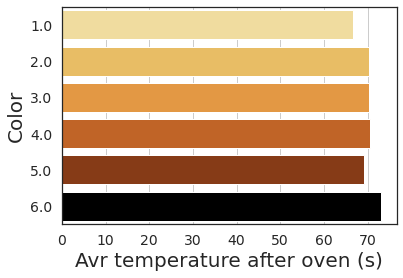

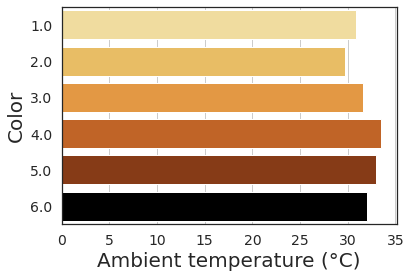

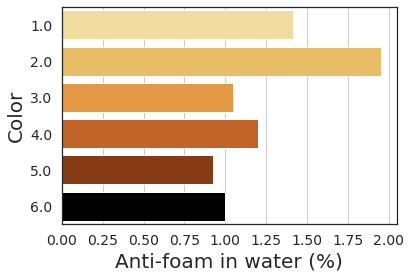

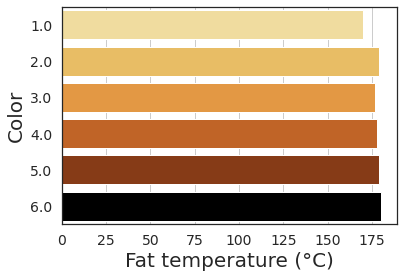

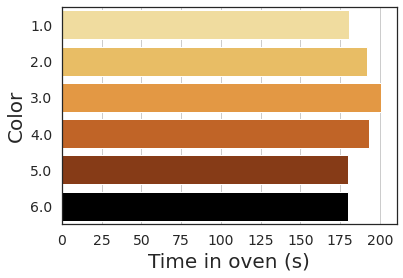

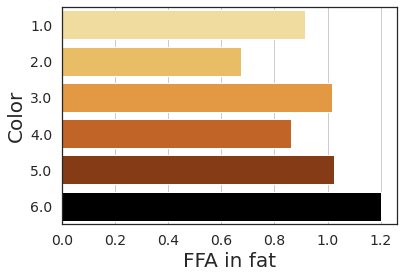

In [26]:
import pandas as pd
import baby_potato as bp

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
color_best_features = pd.read_pickle('color_best_features.pkl')

cols = color_best_features.index[:10].to_list()

data=data
clr_palette = bp.color_palette()
y='Color' 

for j in range(len(cols)) :
    x=cols[j]

    bp.my_barplot(data, x, y, palette=clr_palette)


## Modeling Color as a regression problem

While a classification approach may be suitable for modeling the color of potatoes, it may not be adequate for predicting how other features would behave in hypothetical "what if" scenarios, later in this study. Therefore, alternative methods should be considered for comprehensive analysis and accurate prediction of color potato behavior under different conditions. In this case, a **glnmet regression** has been selected for this purpose. This a technique that can effectively eliminate coefficients associated with less important features by setting them to zero.

### Cross-validation glnmet regression

In [27]:
import numpy as np
import pandas as pd
import baby_potato as bp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
feat_drop='Waste (kg)'
feat_target='Color'

# Number of cross validations
CV = 30

# data scaler
data_scaler = StandardScaler()
data_scaler.fit(data)
data_s = data_scaler.transform(data)
data_s = pd.DataFrame(data=data_s, columns=data.columns)
# data_s[feat_target] =  ( data[feat_target] )
data_s[feat_target] =  np.sqrt( data[feat_target] )

(color_lr_models_l, color_coeff_l, color_intercept_l, 
 color_l1_ratio_l, color_alpha_l, color_mae_bl_l, 
 color_r2_bl_l, color_mae_l, color_r2_l, color_y_pred_l, 
 color_y_test_l) = bp.linear_regressor_cv(data_s, feat_drop, feat_target, CV=CV, cv=10)

# Print the results 
# print("Baseline MAE   :", ( np.median(color_mae_bl_l) ) )
# print("Avr Models MAE :", ( np.median(color_mae_l) ) )
print("Baseline MAE   :", np.square( np.median(color_mae_bl_l) ) )
print("Avr Models MAE :", np.square( np.median(color_mae_l) ) )
print("Baseline  R^2  :", np.median(color_r2_l))
print("Avr Models R^2 :", np.median(color_r2_bl_l))

print("l1 ratio : " , np.median(color_l1_ratio_l) )
print("alpha : " , np.median(color_alpha_l) )

Baseline MAE   : 0.05225480525365136
Avr Models MAE : 0.03454953742920867
Baseline  R^2  : 0.49277283276267314
Avr Models R^2 : -0.03340165462743805
l1 ratio :  0.1
alpha :  0.1


### Residual analysis

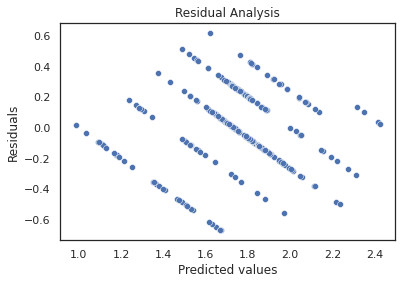

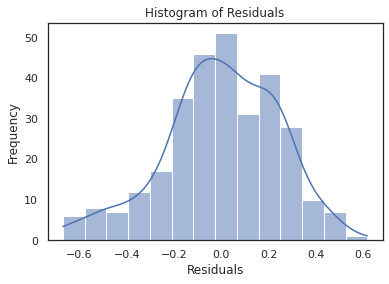

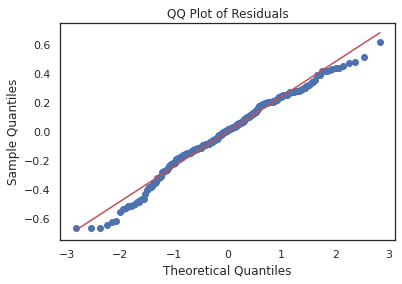

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Calculate the residuals
residuals = color_y_test_l - color_y_pred_l

# Plot the residuals against the predicted values
sns.scatterplot(x=color_y_pred_l, y=residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# Plot a histogram of the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Plot a QQ plot of the residuals
probplot(residuals, plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot of Residuals')
plt.show()

### Color key parameters 

In [29]:
import numpy as np

feature_names = color_lr_models_l[1][1].feature_names_in_ 

color_weights = pd.DataFrame(data=np.median(color_coeff_l, axis=0) ,
                             index=feature_names , 
                             columns=['weight'])

color_best_features = color_weights.abs().sort_values(by='weight', ascending=False)

# save the DataFrame to a pickle file
color_weights.to_pickle('color_weights.pkl')
color_best_features.to_pickle('color_best_features.pkl')

display(color_best_features.head(10) )

,weight
Sugar content (%),0.141053
Time in tank (s),0.112031
Fat temperature (°C),0.085531
Anti-foam in water (%),0.079142
Avr temperature after oven (s),0.068945
Time since last water change (m),0.068714
Time in oven (s),0.046923
Discoloration fraction (%),0.039405
Ambient temperature (°C),0.031800
FFA in fat,0.000000


### Color key parameters plots

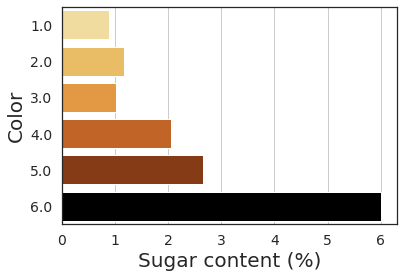

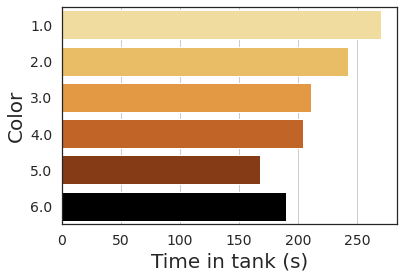

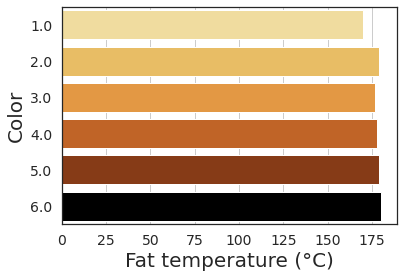

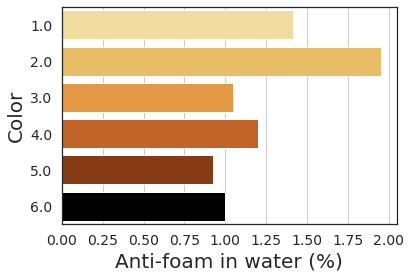

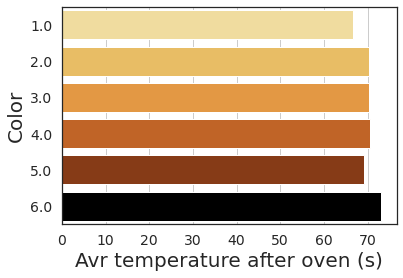

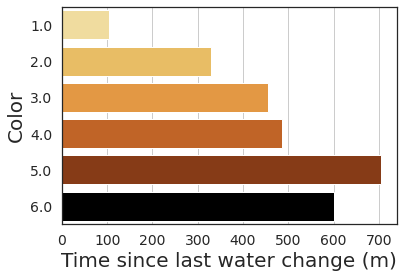

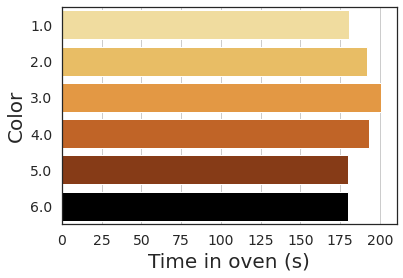

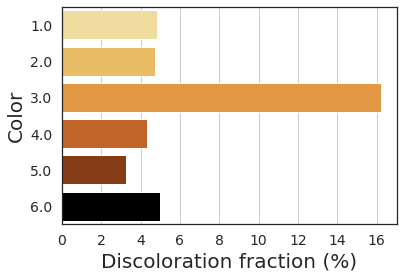

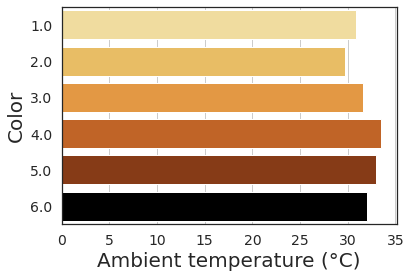

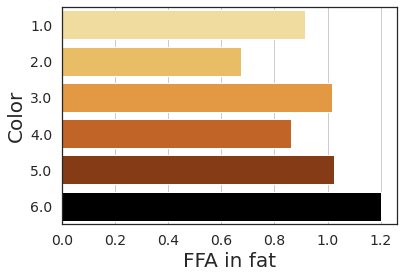

In [30]:
import pandas as pd
import baby_potato as bp

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
color_best_features = pd.read_pickle('color_best_features.pkl')

cols = color_best_features.index[:10].to_list()

data=data
clr_palette = bp.color_palette()
y='Color' 

for j in range(len(cols)) :
    x=cols[j]

    bp.my_barplot(data, x, y, palette=clr_palette)


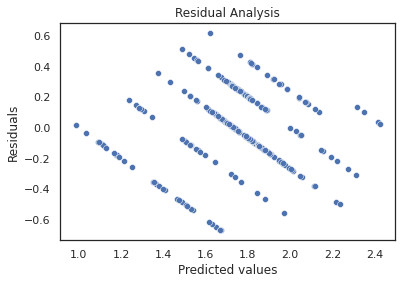

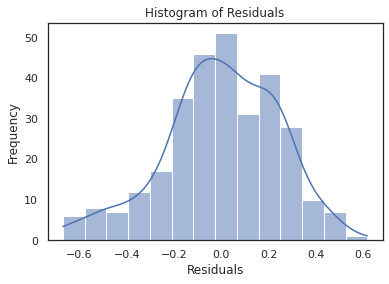

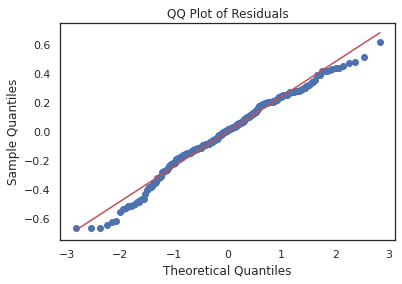

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Calculate the residuals
residuals = color_y_test_l - color_y_pred_l

# Plot the residuals against the predicted values
sns.scatterplot(x=color_y_pred_l, y=residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# Plot a histogram of the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Plot a QQ plot of the residuals
probplot(residuals, plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot of Residuals')
plt.show()

## Modeling Waste as a regression problem

As Waste is a continuous variable, a regression model is required to predict its value based on the other industrial variables. In this case, a **glnmet regression** has been selected for this purpose. This a technique that can effectively eliminate coefficients associated with less important features by setting them to zero.


### Cross-validation glnmet regression

To generate multiple glnmet models, a cross-validation approach is employed. 

For comparison purposes, the mean of the Waste is used as a baseline model. This means that the baseline model always predicts the mean Waste value for any input variable. Later on, the performance of the baseline model will be compared to that of the average glnmet regressors. 

The evaluation metrics used are:
- MAE (mean absolute error). Ideally, MAE should be close to zero. 
- the R2 coefficient. Ideally, R2 should be close to 1.

In [32]:
import numpy as np
import pandas as pd
import baby_potato as bp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
feat_drop='Color'
feat_target='Waste (kg)'

# Number of cross validations
CV = 30

# data scaler
data_scaler = StandardScaler()
data_scaler.fit(data)
data_s = data_scaler.transform(data)
data_s = pd.DataFrame(data=data_s, columns=data.columns)
data_s[feat_target] = np.sqrt(data[feat_target])

(waste_lr_models_l, waste_coeff_l, waste_intercept_l, 
 waste_l1_ratio_l, waste_alpha_l, waste_mae_bl_l, 
 waste_r2_bl_l, waste_mae_l, waste_r2_l, waste_y_pred_l, 
 waste_y_test_l) = bp.linear_regressor_cv(data_s, feat_drop, feat_target, CV=CV, cv=10)

waste_mae_bl_l = np.square ( waste_mae_bl_l )
waste_mae_l = np.square ( waste_mae_l )

# Print the results 
print("Baseline MAE   :", np.median(waste_mae_bl_l))
print("Avr Models MAE :", np.median(waste_mae_l))
print("Baseline  R^2  :", np.median(waste_r2_l))
print("Avr Models R^2 :", np.median(waste_r2_bl_l))

print("l1 ratio : " , np.median(waste_l1_ratio_l) )
print("alpha : " , np.median(waste_alpha_l) )

Baseline MAE   : 5.108310736503645
Avr Models MAE : 5.947980910945051
Baseline  R^2  : -0.22126492829105215
Avr Models R^2 : -0.05959103641799712
l1 ratio :  0.1
alpha :  1.35


### Residual analysis

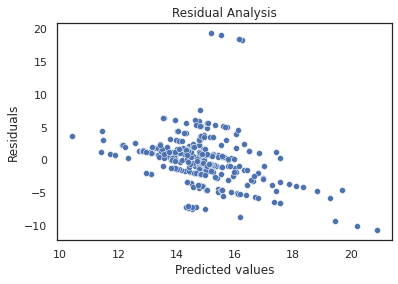

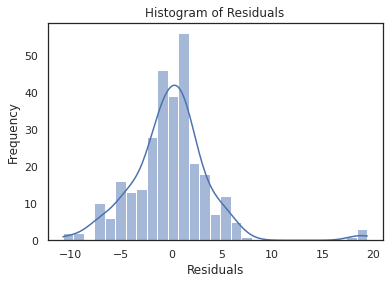

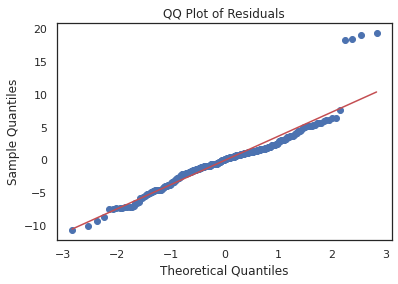

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Calculate the residuals
residuals = waste_y_test_l - waste_y_pred_l

# Plot the residuals against the predicted values
sns.scatterplot(x=waste_y_pred_l, y=residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# Plot a histogram of the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Plot a QQ plot of the residuals
probplot(residuals, plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot of Residuals')
plt.show()

### Model accuracy distribution

The histogram plot of the MAPE reveals that the majority of models exhibit a MAPE of around 0.2, indicating that for some specific training and testing data, the regressor has a relatively good performance. While this suggests that the overall model could be a promising approach, it also highlights the need for more data to improve its overall performance.

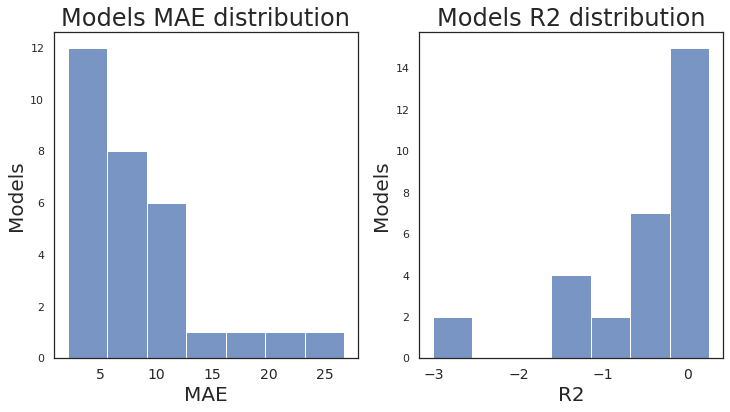

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

sns.set()
sns.histplot(waste_mae_l, ax=axes[0])
sns.histplot(waste_r2_l, ax=axes[1])

axes[0].set_ylabel("Models", fontsize=20)
axes[0].set_xlabel('MAE', fontsize=20)
axes[0].set_title("Models MAE distribution", fontsize=24)
axes[0].tick_params(axis='x', labelsize=14)

axes[1].set_ylabel("Models", fontsize=20)
axes[1].set_xlabel('R2', fontsize=20)
axes[1].set_title("Models R2 distribution", fontsize=24)
axes[1].tick_params(axis='x', labelsize=14)

plt.show()

### Waste key parameters 

As previously mentioned, the glmnet model selects the most important features while adjusting the model coefficients. It achieves this by setting the coefficients of the less important features to zero.

After cross-validation, the most important features are averaged and sorted in descending order. According to the ranking table below, Sugar content is the most influential feature in predicting waste of potatoes after oven, followed by Time since last water change to a lesser extent. 

In [35]:
import numpy as np

feature_names = waste_lr_models_l[1][1].feature_names_in_ 

waste_weights = pd.DataFrame(data=np.median(waste_coeff_l, axis=0) ,
                             index=feature_names , 
                             columns=['weight'])

waste_best_features = waste_weights.abs().sort_values(by='weight', ascending=False)

# save the DataFrame to a pickle file
waste_weights.to_pickle('waste_weights.pkl')
waste_best_features.to_pickle('waste_best_features.pkl')

display(waste_best_features.head(10) )

,weight
Sugar content (%),0.870432
Time since last water change (m),0.336206
Humidity,0.301297
FFA in fat,0.207773
Discoloration fraction (%),0.193501
Time in oven (s),0.152047
Anti-foam in water (%),0.094111
Ambient temperature (°C),0.060396
Fat temperature (°C),0.055794
Time in tank (s),0.000000


### Waste key parameters plots

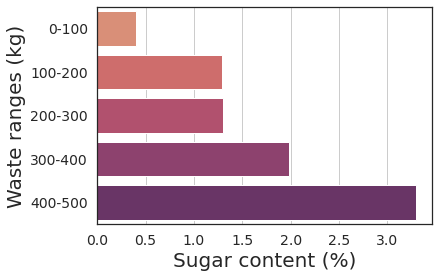

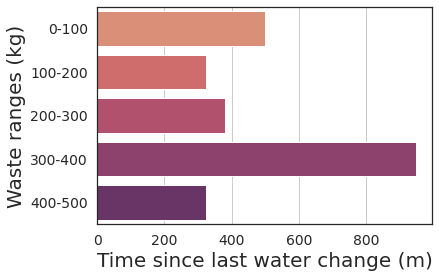

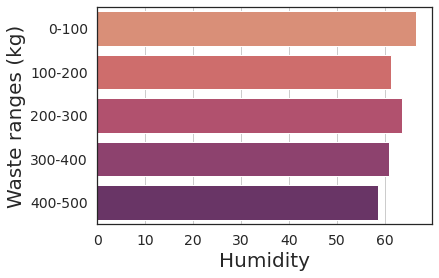

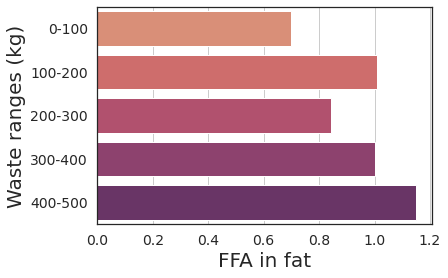

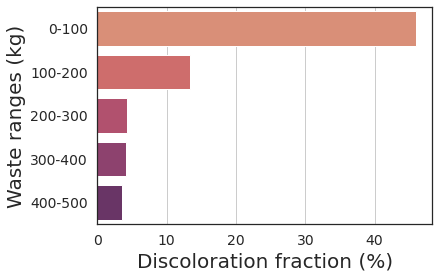

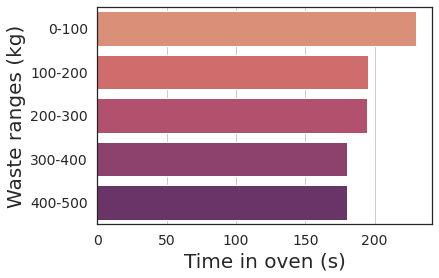

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')

# Create a new column indicating the range of x values
# data['Waste ranges (kg)'] = pd.cut(data['Waste (kg)'], bins=[0, 200, 400, 600], labels=['0-200', '200-400', '400-600'])
data['Waste ranges (kg)'] = pd.cut(data['Waste (kg)'], 
                                   bins=[0, 100, 200, 300, 400, 500], 
                                   labels=['0-100','100-200','200-300','300-400','400-500'])

cols = waste_best_features.index[:6].to_list()

data=data

for j in range(len(cols)) :
    y='Waste ranges (kg)' 
    x=cols[j]

    bp.my_barplot(data=data, x=x, y=y, palette="flare")

## What-if scenarios

### Too much sugar content in potatoes

What if the company is compelled to purchase potatoes with a high sugar content equals to 6? Can the rest of the process parameters be modified to achieve the optimal color and minimum waste?

#### Color

In this scenario, are there any measures that can be taken at the facilities to ensure that the potatoes still come out golden-brown?

Regression coefficients are calculated again without scaling the data, just to work with original variables values.

In [37]:
import numpy as np
import pandas as pd
import baby_potato as bp
from sklearn.preprocessing import StandardScaler

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
feat_drop='Waste (kg)'
feat_target='Color'

# Number of cross validations
CV = 30

(color_lr_models_l, color_coeff_l, color_intercept_l, 
 color_l1_ratio_l, color_alpha_l, color_mae_bl_l, 
 color_r2_bl_l, color_mae_l, color_r2_l, color_y_pred_l, 
 color_y_test_l) = bp.linear_regressor_cv(data, feat_drop, feat_target, CV=CV, cv=10)

# Print the results 
print("Baseline MAE   :", np.median(color_mae_bl_l))
print("Avr Models MAE :", np.median(color_mae_l))
print("Baseline  R^2  :", np.median(color_r2_l))
print("Avr Models R^2 :", np.median(color_r2_bl_l))

print("l1 ratio : " , np.median(color_l1_ratio_l) )
print("alpha : " , np.median(color_alpha_l) )

feature_names = color_lr_models_l[1][1].feature_names_in_ 

color_weights = pd.DataFrame(data=np.median(color_coeff_l, axis=0) ,
                             index=feature_names , 
                             columns=['weight'])

color_best_features = color_weights.abs().sort_values(by='weight', ascending=False)

# save the DataFrame to a pickle file
color_weights.to_pickle('color_weights.pkl')
color_best_features.to_pickle('color_best_features.pkl')

display(color_best_features.head(10) )


Baseline MAE   : 0.8480000000000001
Avr Models MAE : 0.6755509308778038
Baseline  R^2  : 0.36502285403885093
Avr Models R^2 : -0.040000000000000036
l1 ratio :  0.30000000000000004
alpha :  0.1


,weight
Sugar content (%),0.387858
Anti-foam in water (%),0.201864
Fat temperature (°C),0.048612
Avr temperature after oven (s),0.048236
Ambient temperature (°C),0.028903
Humidity,0.011640
Time in tank (s),0.009255
Discoloration fraction (%),0.008755
Time in oven (s),0.008540
Time since last water change (m),0.000698


In [38]:
import numpy as np
import pandas as pd
import baby_potato as bp

# load the data from the pickle file
data = pd.read_pickle('data_potato.pkl')
data = data.drop(['Waste (kg)','Color'] , axis=1)

# data scaler
data_scaler = StandardScaler()
data_scaler.fit(data)
data_s = data_scaler.transform(data)
data_s = pd.DataFrame(data=data_s, columns=data.columns)

color_weights = pd.DataFrame(data=np.median(color_coeff_l, axis=0) ,
                             index=feature_names , 
                             columns=['weight'])
color_intercept = np.mean(color_intercept_l)

# set the features to fix and the desired value of Color
feature_fixed = 'Sugar content (%)'
feature_fixed_value = 6
target_fixed_value = np.sqrt(3)

whatif_features,target_test = bp.whatif_analysis(data=data, weights=color_weights, intercept=color_intercept,                                     
                                    feature_fixed=feature_fixed, 
                                    feature_fixed_value=feature_fixed_value, 
                                    target_fixed_value=target_fixed_value)

print("What-if features :" , whatif_features)    
print("target_test :" , target_test)

What-if features :                                        values
Discoloration fraction (%)        -397.679232
Sugar content (%)                   -3.192703
Time in tank (s)                   600.242751
Anti-foam in water (%)              18.854661
Time since last water change (m) -4676.375257
Fat temperature (°C)               103.314064
Time in oven (s)                  -223.884581
FFA in fat                           0.000000
Avr temperature after oven (s)      -4.017478
Ambient temperature (°C)           -91.381210
Humidity                           368.505515
target_test : [5.3]


#### What-if plot for Color

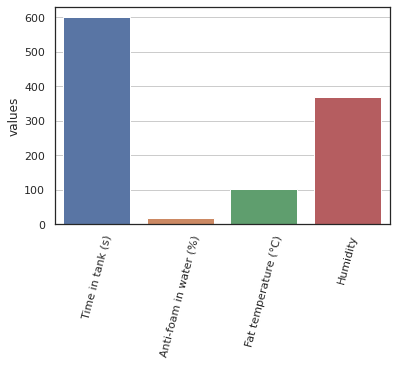

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_theme(style='white')

data = whatif_features [ whatif_features['values'] > 0 ]
y = data['values'] 
x = data.index[:].to_list()

# boxplot using seaborn
ax=sns.barplot(x=x, y=y, orient='v', errorbar=None)
ax.grid(axis='y')
plt.xticks(rotation=75)
# plt.yscale('log')
plt.show()

 #### Waste

 In this scenario, are there any measures that can be taken at the facilities to ensure that the potatoes still come out 200 kg of waste?

In [40]:
import numpy as np
import pandas as pd
import baby_potato as bp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
feat_drop='Color'
feat_target='Waste (kg)'

# Number of cross validations
CV = 30

(waste_lr_models_l, waste_coeff_l, waste_intercept_l, 
 waste_l1_ratio_l, waste_alpha_l, waste_mae_bl_l, 
 waste_r2_bl_l, waste_mae_l, waste_r2_l, waste_y_pred_l, 
 waste_y_test_l) = bp.linear_regressor_cv(data, feat_drop, feat_target, CV=CV, cv=10)

# Print the results 
print("Baseline MAE   :", np.median(waste_mae_bl_l))
print("Avr Models MAE :", np.median(waste_mae_l))
print("Baseline  R^2  :", np.median(waste_r2_l))
print("Avr Models R^2 :", np.median(waste_r2_bl_l))

print("l1 ratio : " , np.median(waste_l1_ratio_l) )
print("alpha : " , np.median(waste_alpha_l) )

feature_names = waste_lr_models_l[1][1].feature_names_in_ 

waste_weights = pd.DataFrame(data=np.median(waste_coeff_l, axis=0) ,
                             index=feature_names , 
                             columns=['weight'])

waste_best_features = waste_weights.abs().sort_values(by='weight', ascending=False)

# save the DataFrame to a pickle file
waste_weights.to_pickle('waste_weights.pkl')
waste_best_features.to_pickle('waste_best_features.pkl')

display(waste_best_features.head(10) )


Baseline MAE   : 74.61800000000001
Avr Models MAE : 94.35831548587987
Baseline  R^2  : -0.2052970614341424
Avr Models R^2 : -0.06117194562630479
l1 ratio :  0.1
alpha :  9.6


,weight
Sugar content (%),11.271528
Humidity,4.688497
Avr temperature after oven (s),4.286901
Ambient temperature (°C),3.114932
Time in oven (s),0.851557
FFA in fat,0.752579
Anti-foam in water (%),0.735941
Discoloration fraction (%),0.310807
Time since last water change (m),0.090673
Fat temperature (°C),0.060462


In [41]:
import numpy as np
import pandas as pd
import baby_potato as bp

# load the data from the pickle file
data = pd.read_pickle('data_potato.pkl')
data = data.drop(['Waste (kg)','Color'] , axis=1)

waste_weights = pd.DataFrame(data=np.median(waste_coeff_l, axis=0) ,
                             index=feature_names , 
                             columns=['weight'])
waste_intercept = np.mean(waste_intercept_l)

# set the features to fix and the desired value of Color
feature_fixed = 'Sugar content (%)'
feature_fixed_value = 6
target_fixed_value = 100

whatif_features,target_test = bp.whatif_analysis(data=data, weights=waste_weights, intercept=waste_intercept,                                     
                                    feature_fixed=feature_fixed, 
                                    feature_fixed_value=feature_fixed_value, 
                                    target_fixed_value=target_fixed_value)

print("What-if features :" , whatif_features)    
print("target_test :" , target_test)

What-if features :                                        values
Discoloration fraction (%)         389.386629
Sugar content (%)                   -4.473266
Time in tank (s)                 -6842.936987
Anti-foam in water (%)             161.598415
Time since last water change (m)  -868.386900
Fat temperature (°C)             -1775.805345
Time in oven (s)                   332.248061
FFA in fat                        -155.918273
Avr temperature after oven (s)      42.362691
Ambient temperature (°C)            -5.918009
Humidity                            87.378583
target_test : [218.05]


#### What-if plot for Waste

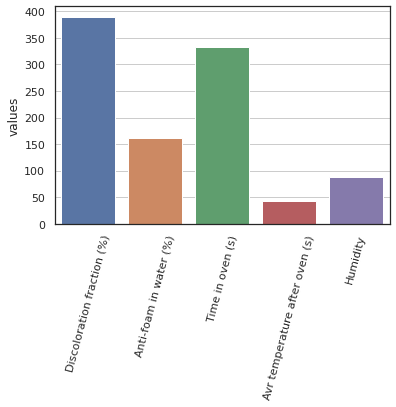

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_theme(style='white')

data = whatif_features [ whatif_features['values'] > 0 ]
y = data['values'] 
x = data.index[:].to_list()

# boxplot using seaborn
ax=sns.barplot(x=x, y=y, orient='v', errorbar=None)
ax.grid(axis='y')
plt.xticks(rotation=75)
plt.show()


## Conclusions

Based on the analysis of the Baby Potato company's data, the following guidelines can be recommended:

- To achieve golden-brown potatoes (level 3):

    1. Sugar content should be around 1%, avoid larger quantities.
    2. Time in the tank should be around 200 seconds.
    3. Water in the tank should be changed every 450 minutes.
    4. Anti-foaming agent in the water should be around 1% .
    5. FFA in fat should be around 0.7.

<p></p>

- To minimize potato waste after cooking:

    1. Sugar content should be less than 1%.
    2. Humidity should be no less than 65.
    3. FFA in fat should be no more than 0.7.
    4. Anti-foam in water should be no less than 1.2%.
    5. Time in oven should be no less than 250 seconds.
    6. Discoloration fraction should be at least 30%.


--- 

# Additional plots

### Waste vs. Color

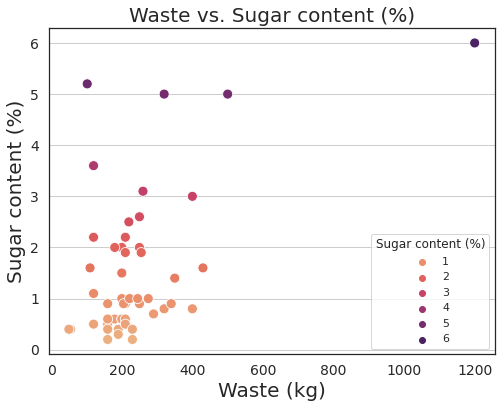

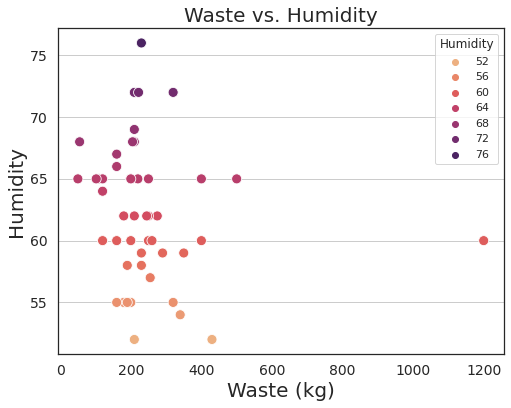

In [43]:
import pandas as pd
import baby_potato as bp

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
waste_best_features = pd.read_pickle('waste_best_features.pkl')

cols = waste_best_features.index[:2].to_list()

for j in range(len(cols)) :
    title = "Waste vs. " + cols[j]
    bp.my_waste_regplot(data=data, x='Waste (kg)', y=cols[j], title=title, 
               xlabel='Waste (kg)', ylabel=cols[j], hue=cols[j])

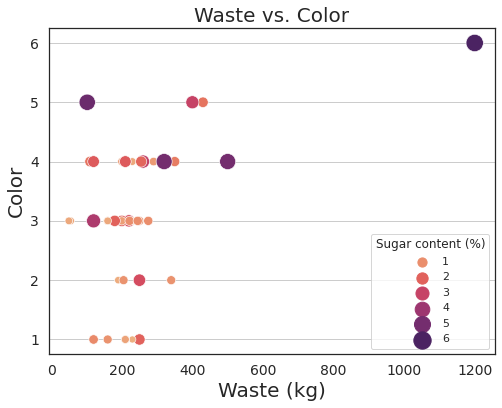

In [44]:
# sns.relplot(data = data, x = 'Waste (kg)', y = 'Color', 
#             hue = 'Sugar content (%)', size = 'Sugar content (%)', sizes=(50,300),
#             palette=sns.color_palette("flare", as_cmap=True))
# plt.grid()

import pandas as pd
import baby_potato as bp

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')

x='Waste (kg)' 
y='Color' 
title='Waste vs. Color'
xlabel=x
ylabel=y

sns.set()
sns.set_theme(style='white')
fig = plt.subplots(figsize=(8, 6))
ax = sns.scatterplot(x=x, y=y, data=data, hue='Sugar content (%)',size = 'Sugar content (%)', sizes=(50,300),
                    palette=sns.color_palette("flare", as_cmap=True) )
plt.title(title, fontsize=20)
plt.xlabel(xlabel, fontsize=20)
plt.ylabel(ylabel, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(axis='y')
# plt.grid()
plt.show()


### Color vs key parameters

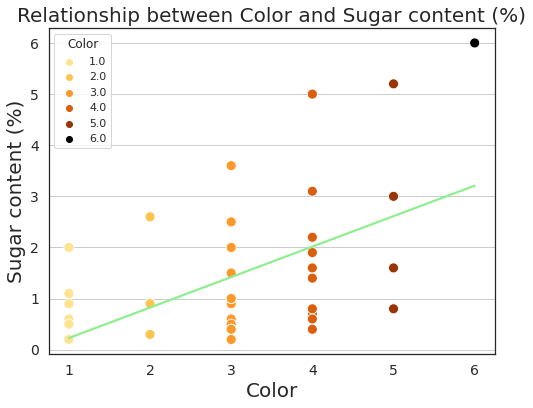

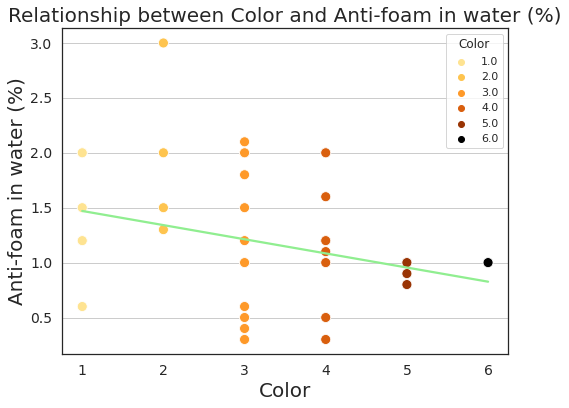

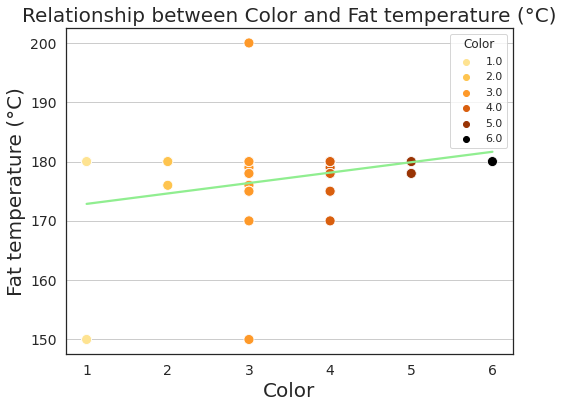

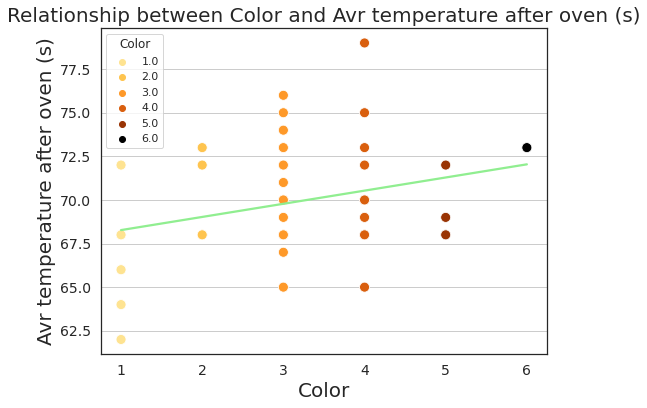

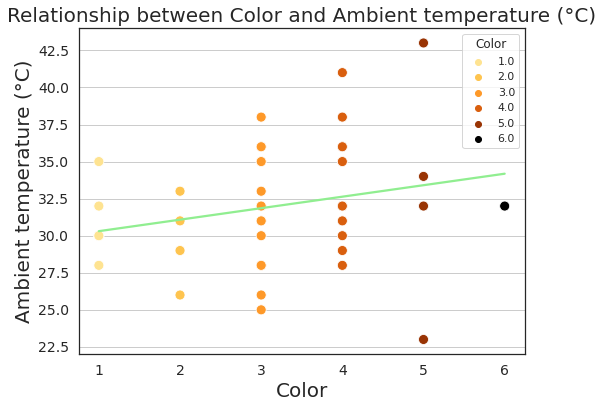

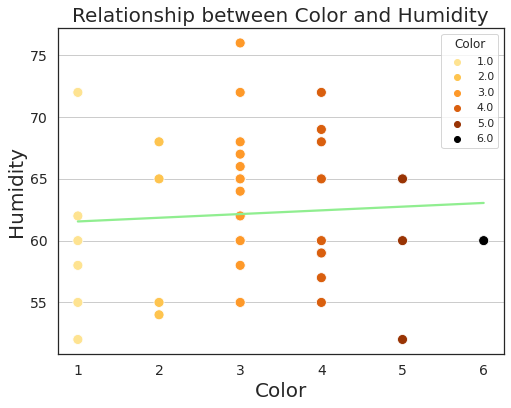

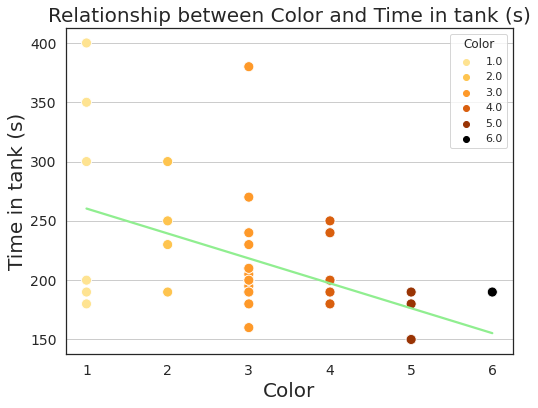

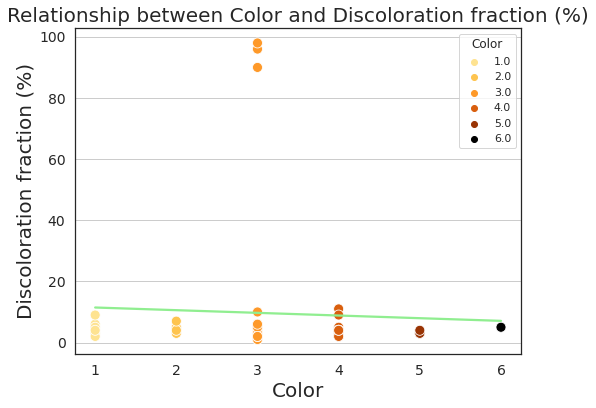

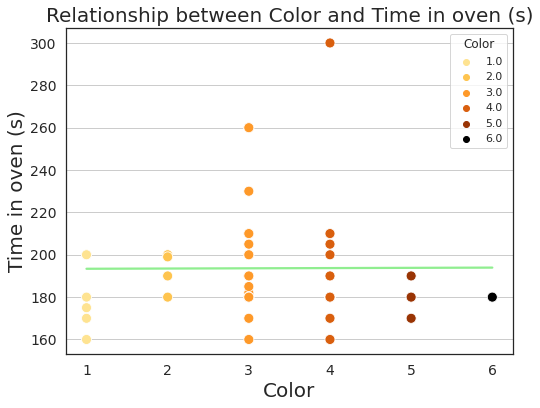

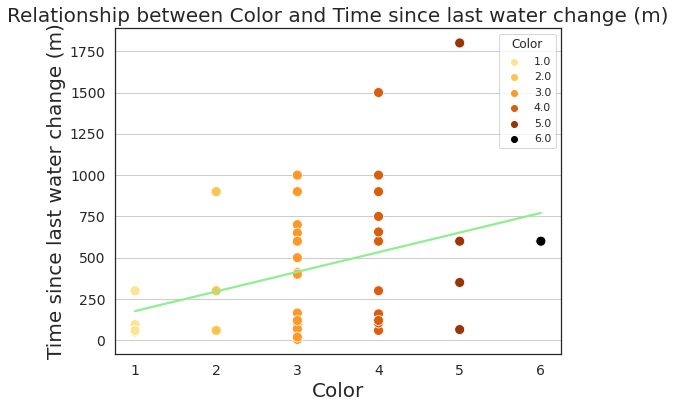

In [45]:
import pandas as pd
import baby_potato as bp

color_palette = bp.color_palette()  

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
color_best_features = pd.read_pickle('color_best_features.pkl')

cols = color_best_features.index[:10].to_list()

for j in range(len(cols)) :
    title = "Relationship between Color and " + cols[j]
    bp.my_regplot(data=data, x='Color', y=cols[j], title=title, 
               xlabel='Color', ylabel=cols[j], hue='Color', pallete=color_palette)

## Waste vs key parameters

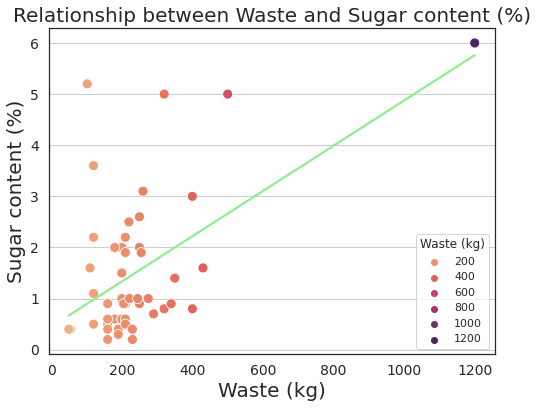

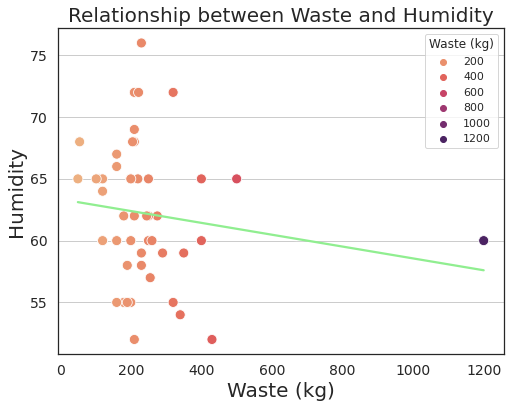

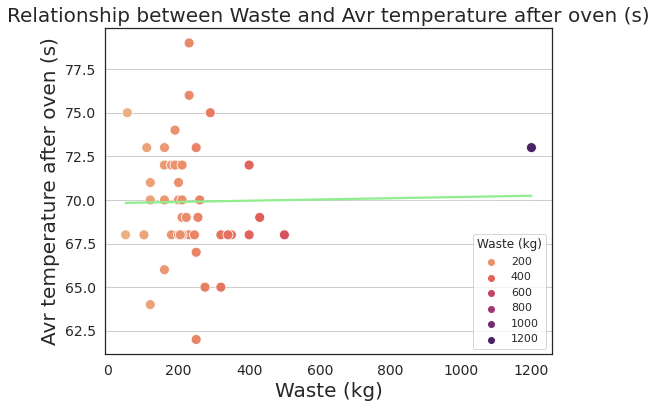

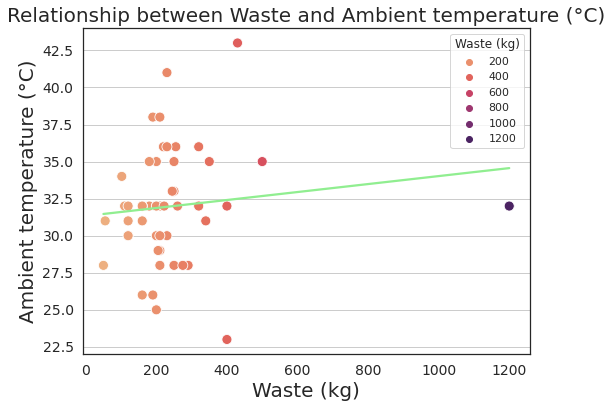

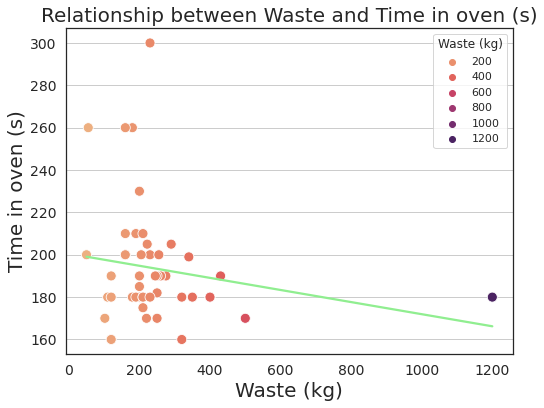

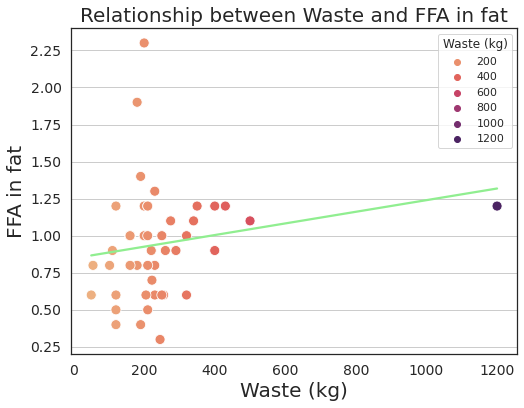

In [46]:
import pandas as pd
import baby_potato as bp

# load the DataFrame from the pickle file
data = pd.read_pickle('data_potato.pkl')
waste_best_features = pd.read_pickle('waste_best_features.pkl')

cols = waste_best_features.index[:6].to_list()

for j in range(len(cols)) :
    title = "Relationship between Waste and " + cols[j]
    bp.my_regplot(data=data, x='Waste (kg)', y=cols[j], title=title, 
               xlabel='Waste (kg)', ylabel=cols[j], hue='Waste (kg)')